# Installing required 

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!pip install scikit-learn
!pip install barplots
!pip install plot_keras_history
!pip install extra_keras_metrics
!pip install epigenomic_dataset>=1.1.7
!pip install ucsc_genomes_downloader>=1.1.22
!pip install keras_bed_sequence>=1.1.5
!pip install seaborn
!pip install boruta
!pip install cmake
!pip install silence_tensorflow>=1.1.1
!pip install minepy
#!pip uninstall imgaug 
#!pip uninstall albumentations 
!pip install git+https://github.com/aleju/imgaug.git
#!pip uninstall matplotlib
!pip install matplotlib==3.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 27.5 MB/s 
     |████████████████████████████████| 323 kB 59.6 MB/s 
     |████████████████████████████████| 930 kB 52.7 MB/s 
  Created wheel for barplots: filename=barplots-1.1.23-py3-none-any.whl size=19981 sha256=0e401927dec532ffb786bf4532bf1abd9e96c78df62779bbc03e59a9aa83a908
  Stored in directory: /root/.cache/pip/wheels/0e/53/1a/16170218f99637bce2848cdb956813aec7c66be23b696aff5c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.42-py3-none-any.whl size=322677 sha256=d6fb0c08ec21052c12407c9fa0071298f60e63a5dcf555aff8cfd1be4c98cc40
  Stored in directory: /root/.cache/pip/wheels/97/31/a0/5ddbb26189896b5d23d83b03bf9a74327a8091a610a6375785
  Created wheel for compress-json: filename=compress_json-1.0.7-py3-none-any.whl s

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9236 sha256=0d61d685c849c26dc6ff12417f62a3e5619f7bb5ffb96f574f7c06b0e3d9537f
  Stored in directory: /root/.cache/pip/wheels/ca/73/ed/41022b42c1d9ce60a8a2ebb71f042c7f895673760404d39fd7
Successfully built plot-keras-history
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-2.0.7-py3-none-any.whl size=14326 sha256=270debf7c054cdf6660113a228772d24fecd71c0913797809b52db1b94abe6fc
  Stored in directory: /root/.cache/pip/wheels/bc/31/f6/215e9129ce789833e29c20b3f9ac9bc73a53de3222ce7f5dd3
Successfully built extra-keras-metrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python

# Importing Packages

In [ ]:
from tqdm.auto import tqdm # A simple loading bar
import matplotlib.pyplot as plt # A standard plotting library
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
from glob import glob 
import seaborn as sns
from cache_decorator import Cache
from typing import Dict, List, Tuple, Optional
from scipy.stats import spearmanr
from scipy.stats import entropy
from sklearn.metrics.pairwise import euclidean_distances
from keras_bed_sequence import BedSequence
from epigenomic_dataset import load_epigenomes

# Distribution of the dataset

In [ ]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset import active_promoters_vs_inactive_promoters

window_size = 256
cell_line="H1"
assembly="hg38"

H1
One of the most commonly used Human Embryonic stem cell line.

# Retrieval of ENCODE epigenomic data

Retrieving the preprocessed data

In [ ]:
X_enhancers, y_enhancers = active_enhancers_vs_inactive_enhancers(
    cell_line = cell_line,
    dataset = "fantom",
    window_size = window_size,

)
X_promoters, y_promoters = active_promoters_vs_inactive_promoters(
    cell_line = cell_line,
    dataset = "fantom",
    window_size = window_size,
   
)

In [ ]:
epigenomes = {
    "promoters": X_promoters,
    "enhancers": X_enhancers
}
labels = {
    "promoters": y_promoters,
    "enhancers": y_enhancers 
}

# Binarization of the Labels

For understanding better why using binarizing is becasue we saw kind of exponential distribution and ranges from 0 to 8000 and 0 to 15

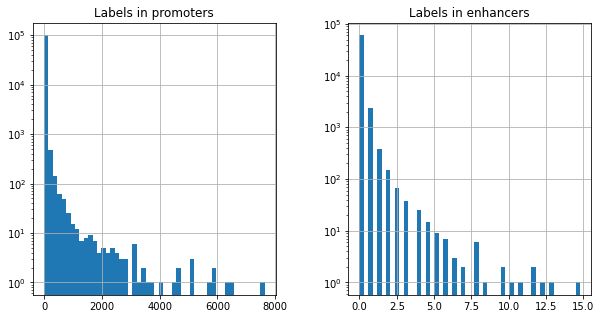

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, lbl) in zip(axes, labels.items()):
    lbl.hist(ax = axis, bins = 50, log = True)
    axis.set_title('Labels in ' + region)


Distribution is unbalanced in the output.
Values on the x axis are way different.



In order to convert the real values of the labels to a binary task, we can consider multiple approaches each one with its own issues. 

Threshold at 1TPMs, dropping values between 0 and 1 for both promoters and enhancers. This setup, which has been suggested by the FANTOM5 authors, removes a portion of the samples, but removes the issue of the threshold.

Testing different threshold

In [ ]:
def threshold(labels:dict,promoters_threshold:int,enhancers_threshold:int)-> tuple:
  rate1 = (labels['promoters']['H1']> promoters_threshold).mean()
  rate2 = (labels['enhancers']['H1']> enhancers_threshold).mean()
    
  return print('promoters_rate: ' + str(rate1),'enhancers_rate: '+ str(rate2))

In [ ]:

threshold(labels,5,0)
threshold(labels, 1, 1)
threshold(labels, 1, 0) # best one so far

#we understand that dropoing values between 0 and 1 is good for both enhancers and promoters
#seco d thing we understabd is threshold for enhcancers

promoters_rate: 0.13344880407685145 enhancers_rate: 0.04800505649047958
promoters_rate: 0.25589451447222195 enhancers_rate: 0.011298095915303785
promoters_rate: 0.25589451447222195 enhancers_rate: 0.04800505649047958


As seen above Threshold at 1TPM decreased the unbalance for the promoters from rate 0.13 to 0.25 but for **the enhancers it is increased from 0.04 to 0.01**.
This tells us we need to use different method for the enhancers.


Threshold at 1TPMS for both enhancers and promoters and dropping values between 0 and 1

In [ ]:


def drop_01_binarization_1() -> dict:
    labels_drop = {}
    
    for region, data in labels.items():
    
        df = labels[region]
        df_drop = df[(df['H1'] == 0) | (df['H1'] >= 1)] 
        df_drop = df_drop['H1'] > 1
        labels_drop[region] = df_drop
    
    return labels_drop

labels_drop = drop_01_binarization_1()


In [ ]:
print('promoters_rate: ' + str(labels_drop['promoters'].mean()), 'enhancers_rate: ' + str(labels_drop['enhancers'].mean()))

promoters_rate: 0.28320535407594544 enhancers_rate: 0.011728617827499097


Continue from the dropped labels lets set the threshold to the 1 for promoters and 0 for enhancers

Threshold at 1 without dropping values

promoters_rate: H1    0.255895
dtype: float64 enhancers_rate: H1    0.011298
dtype: float64


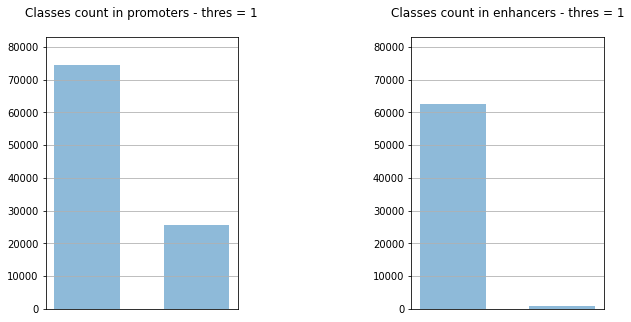

In [ ]:
enhancers, enhancers_labels_bin = active_enhancers_vs_inactive_enhancers(cell_line='H1', binarize = True)
promoters, promoters_labels_bin = active_promoters_vs_inactive_promoters(cell_line='H1', binarize = True)

labels_bin_th1= {
    "promoters": promoters_labels_bin,
    "enhancers": enhancers_labels_bin
}

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, lbl) in zip(axes.ravel(), labels_bin_th1.items()):
    lbl['H1'].astype(int).hist(ax=axis, bins=2, alpha=0.5, rwidth=0.6)
    axis.set_title(f"Classes count in {region} - thres = 1", pad=20)
    plt.subplots_adjust(wspace = 0.9)
    axis.set_xticks([])
    axis.set_ylim(0, 83000)


print('promoters_rate: ' + str(labels_bin_th1['promoters'].mean()), 'enhancers_rate: ' + str(labels_bin_th1['enhancers'].mean())) 

For the conclusion 
Promoters threshold at 1 without dropping values,

enhancers threshold at 0 without dropping values will be used during project.


In [ ]:
enhancers, enhancers_labels_upd = active_enhancers_vs_inactive_enhancers(cell_line='H1', binarize=True)
promoters, promoters_labels_upd = active_promoters_vs_inactive_promoters(cell_line='H1', binarize=True)

labels_bin = {
    "promoters": {},
    "enhancers": {}
}
labels_bin['promoters'] = labels['promoters']  > 1
print('Promoters: ',labels_bin['promoters'] .mean())
########
labels_bin['enhancers']  = labels['enhancers']  > 0
print('Enhancers: ',labels_bin['enhancers'] .mean())


Promoters:  H1    0.255895
dtype: float64
Enhancers:  H1    0.048005
dtype: float64


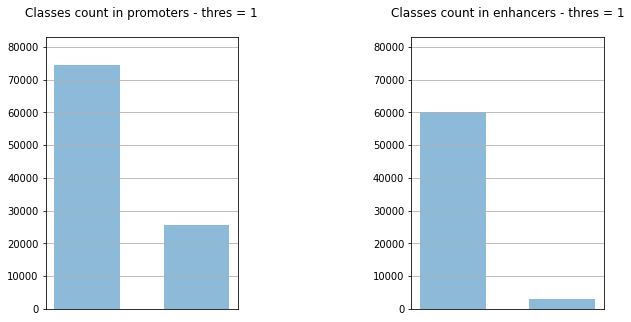

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, lbl) in zip(axes.ravel(), labels_bin.items()):
    lbl['H1'].astype(int).hist(ax=axis, bins=2, alpha=0.5, rwidth=0.6)
    axis.set_title(f"Classes count in {region} - thres = 1", pad=20)
    plt.subplots_adjust(wspace = 0.9)
    axis.set_xticks([])
    axis.set_ylim(0, 83000)

====

In [ ]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters

X, y = active_promoters_vs_inactive_promoters(cell_line=cell_line)

In [ ]:
y

H1
chrom chromStart chromEnd  strand          
chr1  628964     629220    +       0.765552
      629013     629269    +       0.000000
      629642     629898    +       0.000000
      629847     630103    +       0.000000
      629905     630161    +       2.296655
...                                     ...
chrX  154441877  154442133 +       0.000000
      154584927  154585183 +       0.000000
chrY  1452882    1453138   -       0.765552
      2500959    2501215   -       1.531104
      14055973   14056229  +       0.000000

[99881 rows x 1 columns]

#Pre Processing/ Data Elaboration

Rate between features and sample

In [ ]:
for region, x in epigenomes.items():
    print(
        f"The rate between features and samples for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The rate between features and samples for promoters data is: 1722.0862068965516
The rate between features and samples for enhancers data is: 1091.1206896551723


**Nan- Detection**

In [ ]:
for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:",
        f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
        f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
    )))
    print("="*80)

Nan values report for promoters data:
In the document there are 19 NaN values out of 5793098 values.
The sample (row) with most values has 1 NaN values out of 58 values.
The feature (column) with most values has 1 NaN values out of 99881 values.
Nan values report for enhancers data:
In the document there are 1 NaN values out of 3670530 values.
The sample (row) with most values has 1 NaN values out of 58 values.
The feature (column) with most values has 1 NaN values out of 63285 values.


**Neighbours imputation**

In [ ]:
from sklearn.impute import KNNImputer

def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

We used KNN imputation for our data

In [ ]:
epigenomes['promoters'] = knn_imputer(epigenomes['promoters'])
epigenomes['enhancers'] = knn_imputer(epigenomes['enhancers'])

In [ ]:
for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:",
        f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
        f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
    )))
    print("="*80)

Nan values report for promoters data:
In the document there are 0 NaN values out of 5793098 values.
The sample (row) with most values has 0 NaN values out of 58 values.
The feature (column) with most values has 0 NaN values out of 99881 values.
Nan values report for enhancers data:
In the document there are 0 NaN values out of 3670530 values.
The sample (row) with most values has 0 NaN values out of 58 values.
The feature (column) with most values has 0 NaN values out of 63285 values.


Control for NAN values after imputation 

**Constant Features**

In [ ]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [ ]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


**Z scoring**



In [ ]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [ ]:
# Dictionary comprehension
epigenomes = {
    region: robust_zscoring(x)
    for region, x in epigenomes.items()
}

Preprocessing part finished

# Feature Correlations
Another filter we can apply to our features is a correlation with the output labels. If our features do not have any kind of correlation with the output, we can consider dropping them.

**Correlation with output**

In [ ]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [ ]:
uncorrelated_fetures = {
    region: set()
    for region in epigenomes
}

**Linear correlations**

In [ ]:
from scipy.stats import pearsonr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, "correlation:" ,correlation,"pvalue", p_value)
            uncorrelated_fetures[region].add(column)
            print(f"The feature {column} does not correlate in a statistically significant manner with the output.")
            print("")

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

promoters H3K79me2 correlation: -0.00660736303260221 pvalue 0.036781174483733546
The feature H3K79me2 does not correlate in a statistically significant manner with the output.

promoters RAD21 correlation: 0.0039764355583945254 pvalue 0.20886222929956053
The feature RAD21 does not correlate in a statistically significant manner with the output.



Running Pearson test for enhancers:   0%|          | 0/58 [00:00<?, ?it/s]

enhancers SUZ12 correlation: -0.0037773898357398 pvalue 0.3419882479033172
The feature SUZ12 does not correlate in a statistically significant manner with the output.

enhancers RNF2 correlation: 0.004393295671961831 pvalue 0.2690801404561644
The feature RNF2 does not correlate in a statistically significant manner with the output.



**Monotonic correlations**
The Spearman correlation coefficient

In [ ]:
from scipy.stats import spearmanr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, "correlation:" ,correlation,"pvalue", p_value)
            uncorrelated_fetures[region].add(column)

Running Spearman test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Running Spearman test for enhancers:   0%|          | 0/58 [00:00<?, ?it/s]

enhancers SUZ12 correlation: -0.003757532146771812 pvalue 0.3445319630768555


In [ ]:
uncorrelated_fetures

{'enhancers': {'RNF2', 'SUZ12'}, 'promoters': {'H3K79me2', 'RAD21'}}

**Non linear correlations**

Since computing non linear correlations is expensive computationally, we will only run the tests for the columns that are not linearly or monotonically correlated.

From monotonically it is SUZ12
FROM non linear corr it is H3K7me2-RNF2

In [ ]:
from minepy import MINE

for region, x in epigenomes.items():
    for column in tqdm(("H3K79me2" ,"RAD21","SUZ12","RNF2"), desc=f"Running MINE test for {region}", leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated_fetures[region].remove(column)

Running MINE test for promoters:   0%|          | 0/4 [00:00<?, ?it/s]

promoters H3K79me2 0.02116227115696734
promoters SUZ12 0.02973452459956543
promoters RNF2 0.01885095655230959


Running MINE test for enhancers:   0%|          | 0/4 [00:00<?, ?it/s]

enhancers H3K79me2 0.017449621495715214
enhancers RAD21 0.040185738345818324
enhancers SUZ12 0.008317427538459508
enhancers RNF2 0.01134222443570095


DROPPED RAD21

In [ ]:
uncorrelated_fetures

{'enhancers': {'RNF2', 'SUZ12'}, 'promoters': {'H3K79me2'}}

Dropping features uncorrelated_fetures

In [ ]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated_fetures[region]
        if col in x.columns
    ])

**Features Correlation**

Now we proceed to identify and drop features that have extremely high Pearson correlation scores (more than 0.8) one-another. These features often do not add significant information when one is removed. If we have to choose to remove a feature, we will remove the one with lower entropy).

In [ ]:
p_value_threshold = 0.01
ccorrelation_threshold = 0.85

High correlations among the features



In [ ]:

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > ccorrelation_threshold:
                print(region, column, feature, correlation)
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

promoters TAF1 POLR2A 0.8939524166139474
promoters H3K27ac H3K9ac 0.8965576515651565
promoters SUZ12 RNF2 0.8530017664983849
promoters POLR2A POLR2AphosphoS5 0.9332611395103301


Running Pearson test for enhancers:   0%|          | 0/58 [00:00<?, ?it/s]

enhancers CTCF RAD21 0.8583613081608245
enhancers POLR2A POLR2AphosphoS5 0.886915239108121
enhancers H3K4me3 H3K4me2 0.8780161221412082


In [ ]:
extremely_correlated


{'enhancers': {'CTCF', 'H3K4me3', 'POLR2A'},
 'promoters': {'H3K27ac', 'POLR2A', 'SUZ12', 'TAF1'}}

#**Visualizations with scatter plots**
We will use seaborn's pairplot method to visualize the most correlated and least correlated features detected using the Pearson coefficient.

We will start by sorting the obtained scores.



In [ ]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

We will start by considering the 3 most correlated touples.

Most correlated features from promoters epigenomes


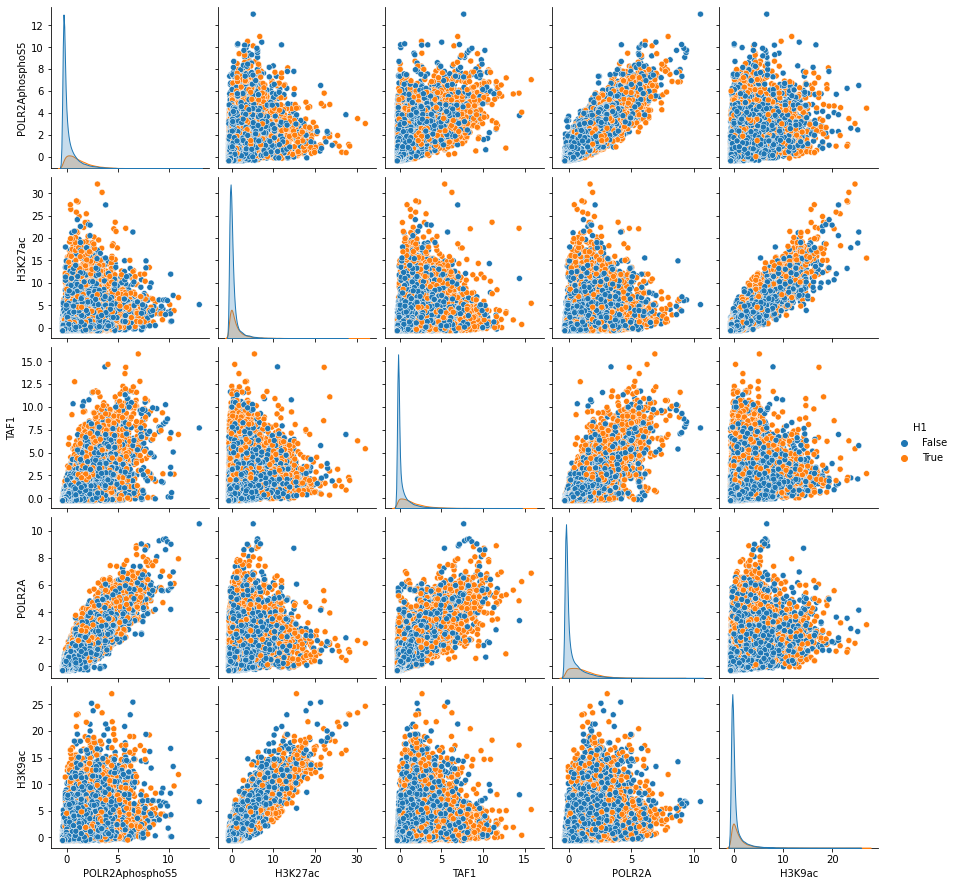

Most correlated features from enhancers epigenomes


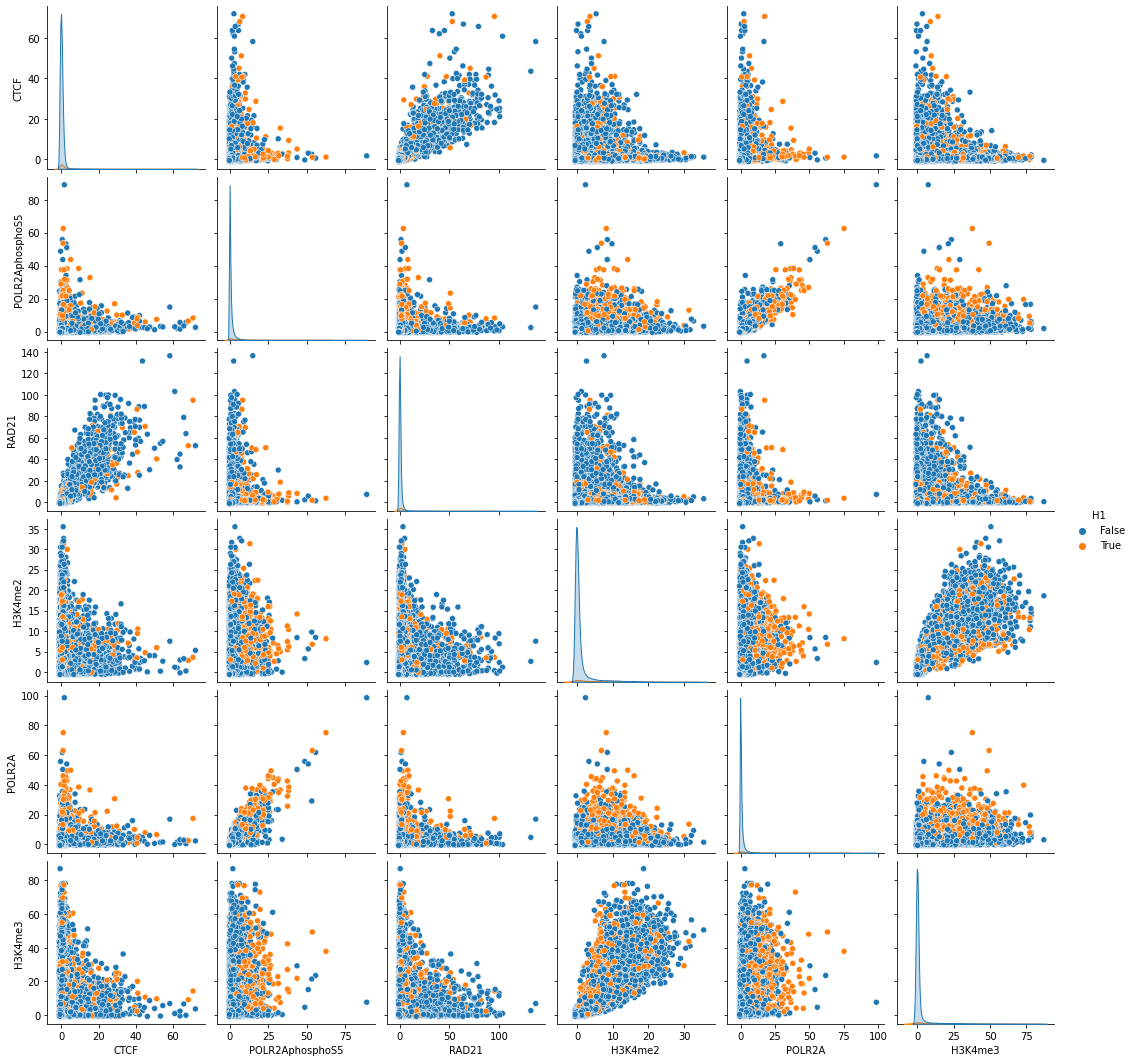

In [ ]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")

    sns.pairplot(pd.concat([
        x[columns],
        labels_bin[region],
    ], axis=1), hue=labels_bin[region].columns[0])

    plt.show()


We will start by considering the 3 most uncorrelated_fetures touples.

Least correlated features from promoters epigenomes


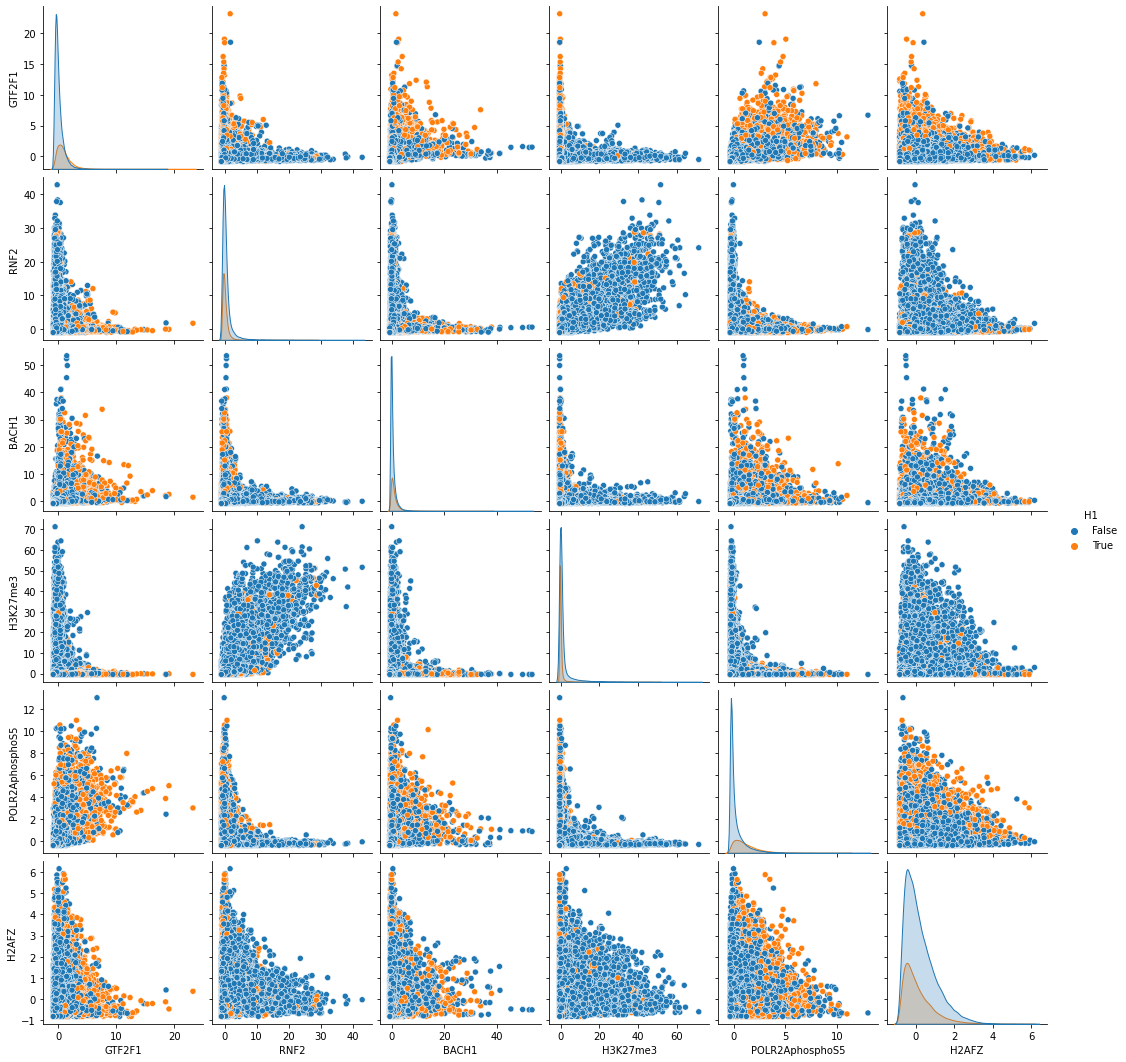

Least correlated features from enhancers epigenomes


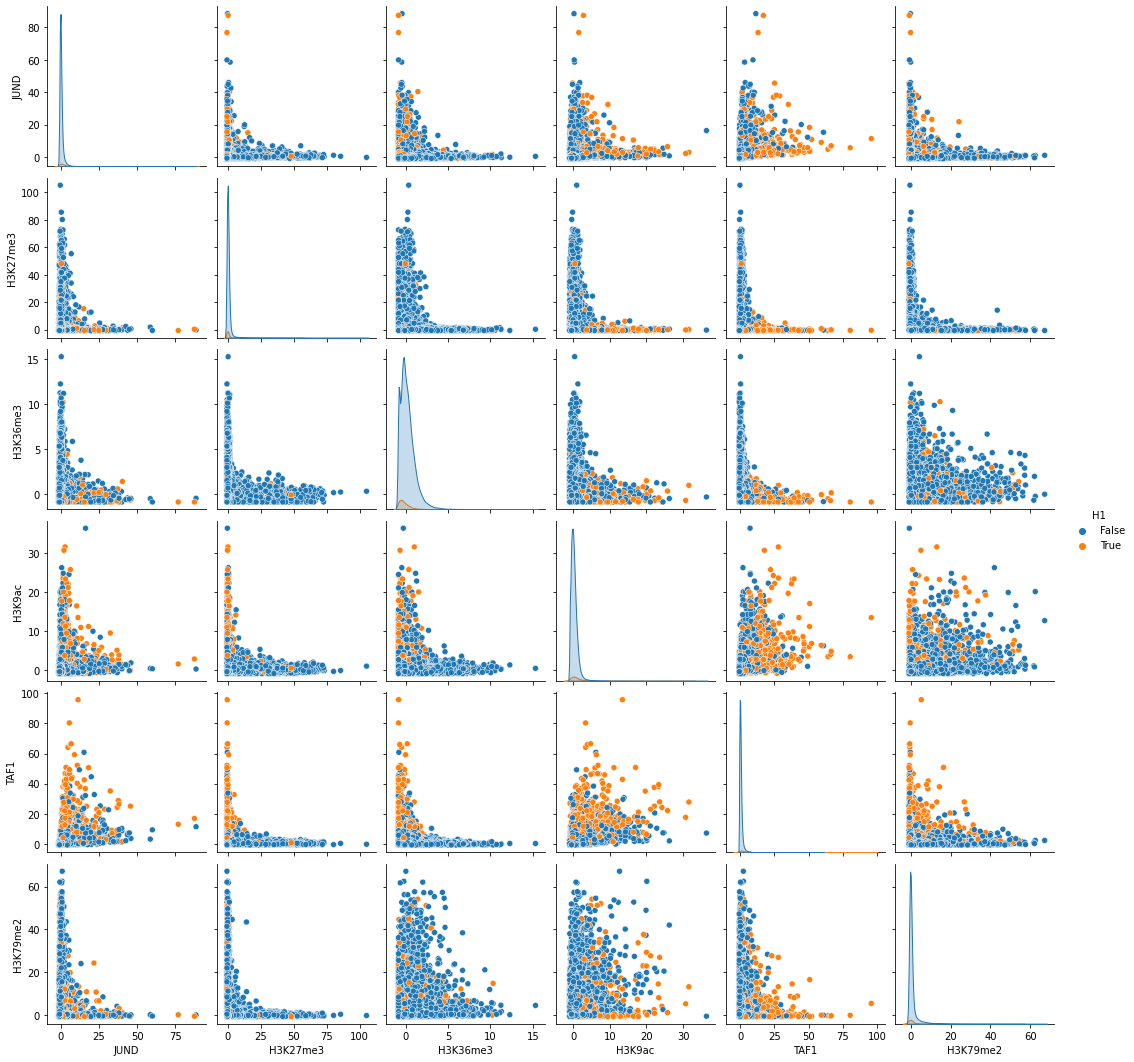

In [ ]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][-3:]))
    columns = list(set(firsts+seconds))
    print(f"Least correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels_bin[region],
    ], axis=1), hue=labels_bin[region].columns[0])
    plt.show()


# Feature Distributions

To visualize the distributions we will use histograms. Since we cannot show all distributions we select the top 10 most different features. We define the distance between the features using a pairwise euclidean distance.

To reduce the impact of outliers we filter outliers before the 0.01 percentile and the 0.99 percentile.

In [ ]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

In [ ]:
top_number = 5

we will select distance measure Euclidean

Top 5 different features from promoters.


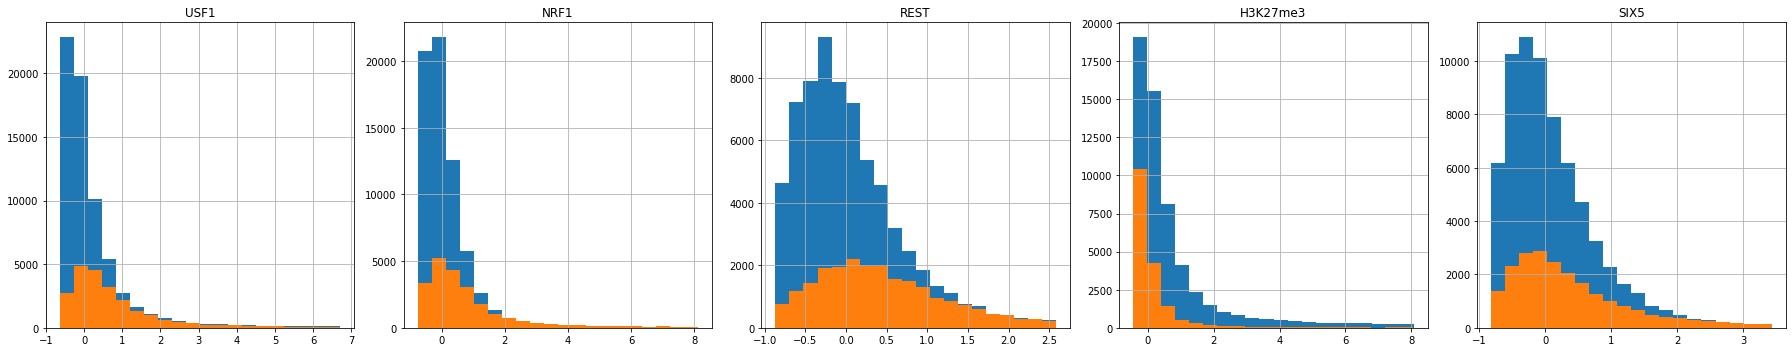

Top 5 different features from enhancers.


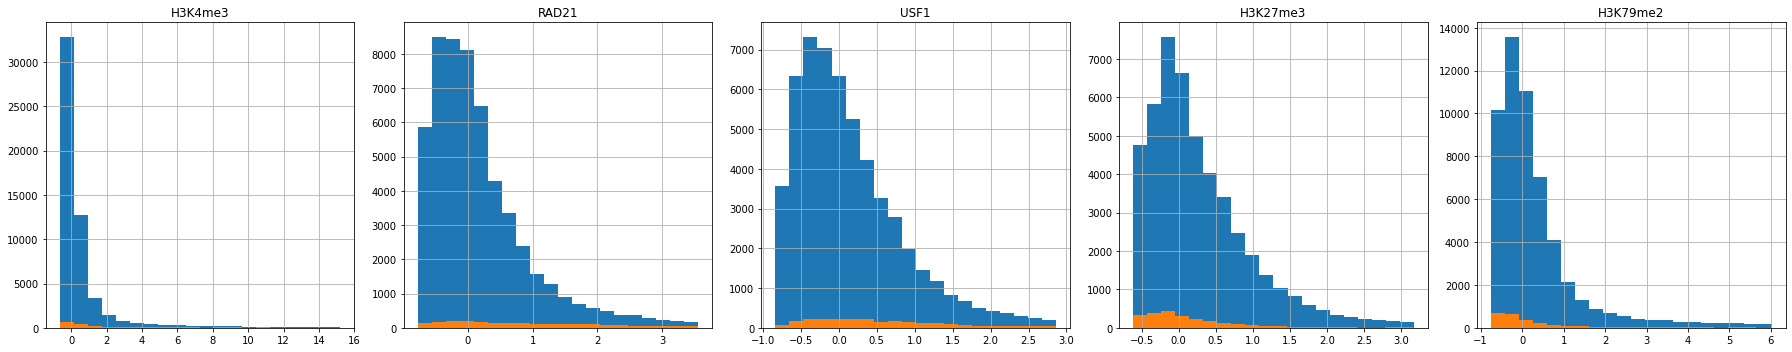

In [ ]:
for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = labels_bin[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)
        
        axis.set_title(column)
    fig.tight_layout()
    plt.show()

# Feature Selection  Boruta with Random Forest Classifier Model

##Boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    #task_name : str 
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    
    # SINCE ONLY USING RANDOM FOREST CLASSIFIER WE DO NOT NEED IF ELSE STATAMENT
    model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=True,
        alpha=0.05, 
        max_iter=max_iter, 
        random_state=42
    )

    boruta_selector.fit(X_train.values, y_train)
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])

    
    return kept_features, discarded_features

#Retrieveing Genomic Sequence

In [ ]:
from ucsc_genomes_downloader import Genome

genome = Genome('hg38')

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
genome

Human, Homo sapiens, hg38, 2013-12-30, 25 chromosomes

In [ ]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]



In [ ]:
to_bed(y)

chrom  chromStart   chromEnd strand
0      chr1      628964     629220      +
1      chr1      629013     629269      +
2      chr1      629642     629898      +
3      chr1      629847     630103      +
4      chr1      629905     630161      +
...     ...         ...        ...    ...
99876  chrX   154441877  154442133      +
99877  chrX   154584927  154585183      +
99878  chrY     1452882    1453138      -
99879  chrY     2500959    2501215      -
99880  chrY    14055973   14056229      +

[99881 rows x 4 columns]

In [ ]:
genome.bed_to_sequence(to_bed(y))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


array(['AAATGGTCATCCATCCTTTGGCCCCAATACCTAAACTAAGGTCTATGAACAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAAC',
       'CAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCAAGACCCTAC',
       'AATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAGGCACACTCATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCACAGAAGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGACAATGAACCATAA',
       ...,
       'CTCGGGCGCCACGCGCGTCGCGCCGACGTTTTTTTTGTCCGCCGGTCTCAGGGCGGAGGCGCTCCGGTGCGGGGGCGGGCGGAGGCGCTCCGGTGCGGGTCAGGCGCGGAAGTCACCGGAGGGGCGCTCTGGCGCGGGTCCGGTGCGGAGGTAACTTGTGAGGCAGTCCGGAGCGGGTC

In [ ]:
np.array(BedSequence(
    genome,
    bed=to_bed(y),
    batch_size=1
))

array([[[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]]],


       [[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
     

# Features visualization using TSNE and PCA decompositions


TSNE

In [ ]:
#!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies


In [ ]:
from sklearn.decomposition import PCA
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from sklearn.manifold import TSNE
from cache_decorator import Cache
from sklearn.decomposition import PCA


https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

In [ ]:
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
)->pd.DataFrame:
    """
    Parameters
    ------------------------
    X:pd.DataFrame,
        The dataframe to decompose.

    data_type:str,
        Either sequence or epigenomic.

    region:str,
        Either promoters or enhancers.

    cell_line:str,
        The considered cell line.

    metric:str,
        The metric to use for the decomposition.
    
    perplexity:int,
        The perplexity value to use
    
    Returns
    ------------------------
    Return a DataFrame containing the 2D TSNE decomposition of the given data.
    """
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    TSNE()
    return pd.DataFrame(
    TSNE(
    
         
        metric=metric,  #For define the cosine metric we will use metric=metric 
        verbose=0 #I take verbose level as zero because sklearn.manifold.TSNE doc default value is 0
    ).fit_transform(X.values),
    index=X.index
)

SAME FOR PCA

In [ ]:
@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    """
    Parameters
    ------------------------
    X:pd.DataFrame,
        The dataframe to decompose.

    data_type:str,
        Either sequence or epigenomic.

    region:str,
        Either promoters or enhancers.

    cell_line:str,
        The considered cell line.

    metric:str,
        The metric to use for the decomposition.
    
    Returns
    ------------------------
    Return a DataFrame containing the 2D PCA decomposition of the given data.
    """
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

Define a scatter with a heatmap

In [ ]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Main visualization loop

Not using all the 4 for loop from practice notebook because we are only printing the selected cell,
In practice notebook all the cells are printed

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/us

Task:   0%|          | 0/2 [00:00<?, ?it/s]

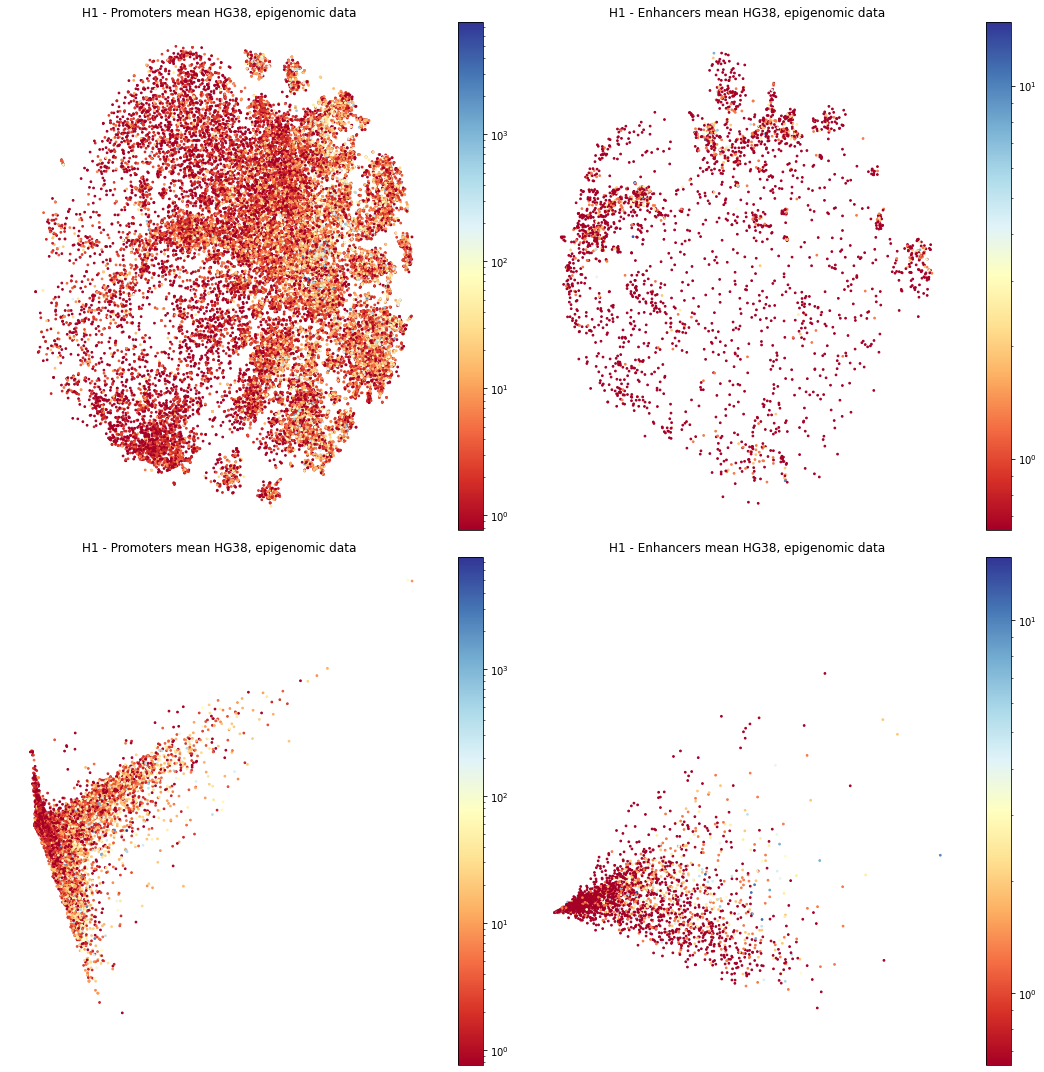

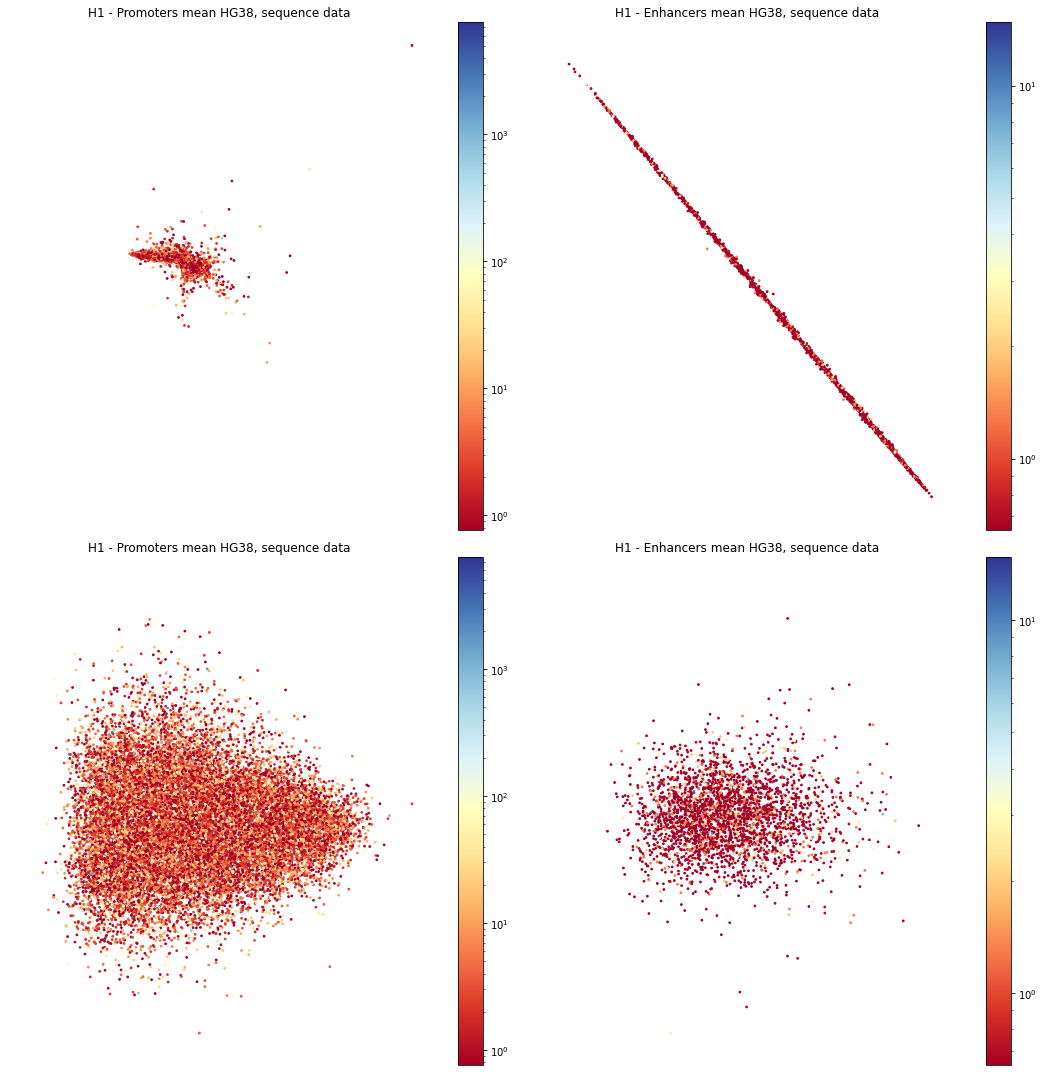

In [ ]:
epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 15),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 15),
    squeeze=False
)
#Since I am not interested in whole cell lines we will not consider these 2 for loops
#for i, cell_line in enumerate(tqdm(get_cell_lines(), desc="Computing decompositions")):
    #for k, metric in enumerate(tqdm(("max", "mean"), desc="Metrics", leave=False)):
for l, decomposition_method in enumerate(tqdm((get_tsne_decomposition, get_pca_decomposition), desc="Decomposition method", leave=False)):
    for j, ((epigenomic, scores), region, clip_value) in enumerate(tqdm((
        ((epigenomes['promoters'], labels['promoters']), "Promoters",1000),
        ((epigenomes['enhancers'], labels['enhancers']), "Enhancers",20)
    ), desc="Task", leave=False)):
        
      #alredy  scaled and imputed date
        """imputed_epigenomic = pd.DataFrame(
            MinMaxScaler().fit_transform(
                KNNImputer().fit_transform(epigenomic)
            ),
            columns=epigenomic.columns,
            index=epigenomic.index
        )"""

        decomposed_epigenomic = decomposition_method(
            epigenomic,
            "epigenomic",
            region,
            cell_line= cell_line,
            metric='cosine',
            
        )
        scores[scores>clip_value] = clip_value
        scatter_with_heatmap(
            decomposition=decomposed_epigenomic,
            scores=scores.values,
            figure=epigenomic_fig,
            ax=epigenomic_axes[l][j]
        )

        sequence = pd.DataFrame(
            np.array(BedSequence(
                genome,
                bed=to_bed(scores),
                batch_size=1
            )).reshape(-1, 4*256),
            index=scores.index
        )

        epigenomic_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, epigenomic data")
        epigenomic_axes[l][j].set_axis_off()
        
        #Since we do not need k fro max mean
        """if k==0:
          sequence = pd.DataFrame(
              np.array(BedSequence(
                  genome,
                  bed=to_bed(scores),
                  batch_size=1
              )).reshape(-1, 4*256),
              index=scores.index
          )"""

        decomposed_sequence = decomposition_method(
            sequence,
            "sequence",
            region,
            cell_line=cell_line,
            metric="cosine",
        )
        scatter_with_heatmap(
            decomposition=decomposed_sequence,
            scores=scores.values,
            figure=sequence_fig,
            ax=sequence_axes[l][j]
        )
        sequence_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, sequence data")
        sequence_axes[l][j].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()

In [ ]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from tensorflow.keras.models import Model
from typing import Tuple
from typing import Dict, List,Optional
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers

from extra_keras_metrics import get_complete_binary_metrics

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 28.8 MB/s 


In [ ]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from epigenomic_dataset.utils import normalize_epigenomic_data
from tensorflow.keras.optimizers import Nadam

In [ ]:
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

# Creating Training Sequence

We are going to use Keras Sequences in order to train the models.

To make it easier to use a mix of epigenomic and sequence data, we use the keras_bed_sequence and the keras_mixed_sequence packages, which you can install by using:

In [ ]:
pip install keras_bed_sequence keras_mixed_sequence -U


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras_mixed_sequence import MixedSequence, VectorSequence


In [ ]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024 
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
        """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:

    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )



**Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    #holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                monitor="loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

# Fixed Binary Class. mODELS

In [ ]:
from tensorflow.keras.optimizers import  Nadam

In [ ]:
all_binary_classification_performance = []

training_histories = {}

window_size = 256
cell_line = "H1"

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# Here for speed sake we are only doing two holdouts

number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

In [ ]:
def build_binary_classification_perceptron(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns perceptron model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    perceptron = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="PERCEPTRON"
    )

    perceptron.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    return perceptron,input_epigenomic_data, output_ffnn

In [ ]:
hp = keras_tuner.HyperParameters()
# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=cell_line,
        window_size=window_size,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold
    )
    training_histories[task_name] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        perceptron, _, _ = build_binary_classification_perceptron(number_of_features)
        for model, train_sequence, test_sequence in tqdm(
            (
                (perceptron, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
            ),
            desc="Training models",
            leave=False
        ):
            # Here we may want to do feature selection with
            # Boruta, but we are skipping it because it requires
            # a lot of time.
            
            # execute_boruta_feature_selection(...)
            
            # We compute the model performance
            history, performance = train_model(
                model,
                model.name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                #holdout_number
            )
            training_histories[task_name].append(history)
            # We chain the computed performance to the performance list
            all_binary_classification_performance.append(performance)
perceptron.summary()
  


Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/1 [00:00<?, ?it/s]

Training models:   0%|          | 0/1 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/1 [00:00<?, ?it/s]

Training models:   0%|          | 0/1 [00:00<?, ?it/s]

Model: "PERCEPTRON"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 epigenomic_data (InputLayer  [(None, 58)]             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1)                 59        
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_binary_classification_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [ ]:
def build_binary_classification_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(
            32,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer = Nadam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [ ]:
def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer=Nadam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#Model evaluation holdouts

In order to evaulate the model we create generator of stratified holdouts for the bianry classification task, that is the same distribution of the output classes within the training and test holdouts.

This is not suitable for regression so we use simpler non strafied random split.


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# Here for speed sake we are only doing two holdouts
# but normally at least 10 are executed
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

###Evaluation of the models predictions

iN order to evaulate models predictions we consider accuracy AUPRC  AUROC  metrics

#####Evaluation of Binary classification task 

In [ ]:

# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=cell_line,
        window_size=window_size,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold
    )
    training_histories[task_name] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        #perceptron, _, _ = build_binary_classification_perceptron(number_of_features)
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        mmnn1 = build_binary_classification_mmnn(number_of_features, window_size)
        mmnn2 = build_binary_classification_mmnn(
            input_sequence_data=input_sequence_data,
            input_epigenomic_data=input_epigenomic_data,
            last_hidden_ffnn=last_hidden_ffnn,
            last_hidden_cnn=last_hidden_cnn
        )
        for model, train_sequence, test_sequence in tqdm(
            (
                #(perceptron, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                (mmnn1, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                (mmnn2, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
            ),
            desc="Training models",
            leave=False
        ):
            # Here we may want to do feature selection with
            # Boruta, but we are skipping it because it requires
            # a lot of time.
            
            # execute_boruta_feature_selection(...)
            
            # We compute the model performance
            history, performance = train_model(
                model,
                model.name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                #holdout_number
            )
            training_histories[task_name].append(history)
            # We chain the computed performance to the performance list
            all_binary_classification_performance.append(performance)
ffnn.summary()
cnn.summary()
mmnn1.summary()
# We convert the computed performance list into a DataFrame
#all_binary_classification_performance_dataframe = pd.concat(all_binary_classification_performance)


Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Model: "BinaryClassificationFFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 epigenomic_data (InputLayer  [(None, 58)]             0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 59        
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
Model: "BinaryClassificationCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_data (InputLayer)  [(None, 256, 4)]          0         
                                                                 
 conv1d (Conv1D)             (None, 251, 64)           1600      
             

In [ ]:
print(type(all_binary_classification_performance))

<class 'list'>


In [ ]:
all_binary_classification_performance_dataframe = pd.concat(all_binary_classification_performance)

Rendering barplots:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/barplots/utils/get_axes.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  dpi=dpi


[(<Figure size 1600x840 with 2 Axes>,
  array([<AxesSubplot:title={'center':'Active enhancers VS inactive enhancers'}, xlabel='Balanced Accuracy'>,
         <AxesSubplot:title={'center':'Active promoters VS inactive promoters'}, xlabel='Balanced Accuracy'>],
        dtype=object)),
 (<Figure size 1600x840 with 2 Axes>,
  array([<AxesSubplot:title={'center':'Active enhancers VS inactive enhancers'}, xlabel='False positives over total'>,
         <AxesSubplot:title={'center':'Active promoters VS inactive promoters'}, xlabel='False positives over total'>],
        dtype=object)),
 (<Figure size 1600x840 with 2 Axes>,
  array([<AxesSubplot:title={'center':'Active enhancers VS inactive enhancers'}, xlabel='Matthews correlation coefficient'>,
         <AxesSubplot:title={'center':'Active promoters VS inactive promoters'}, xlabel='Matthews correlation coefficient'>],
        dtype=object)),
 (<Figure size 1600x840 with 2 Axes>,
  array([<AxesSubplot:title={'center':'Active enhancers VS inacti

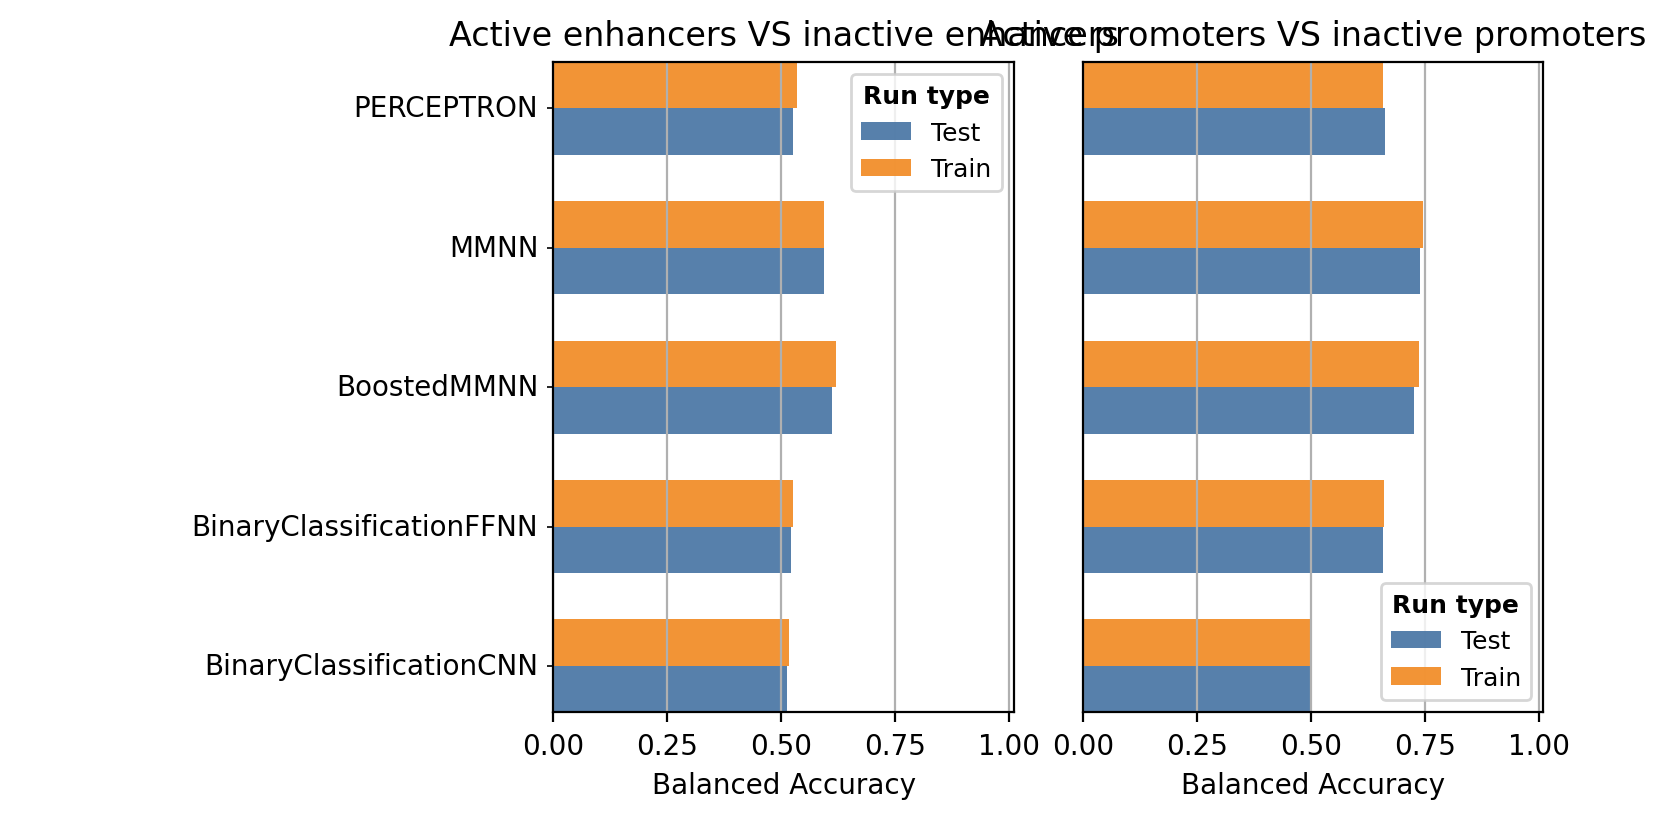

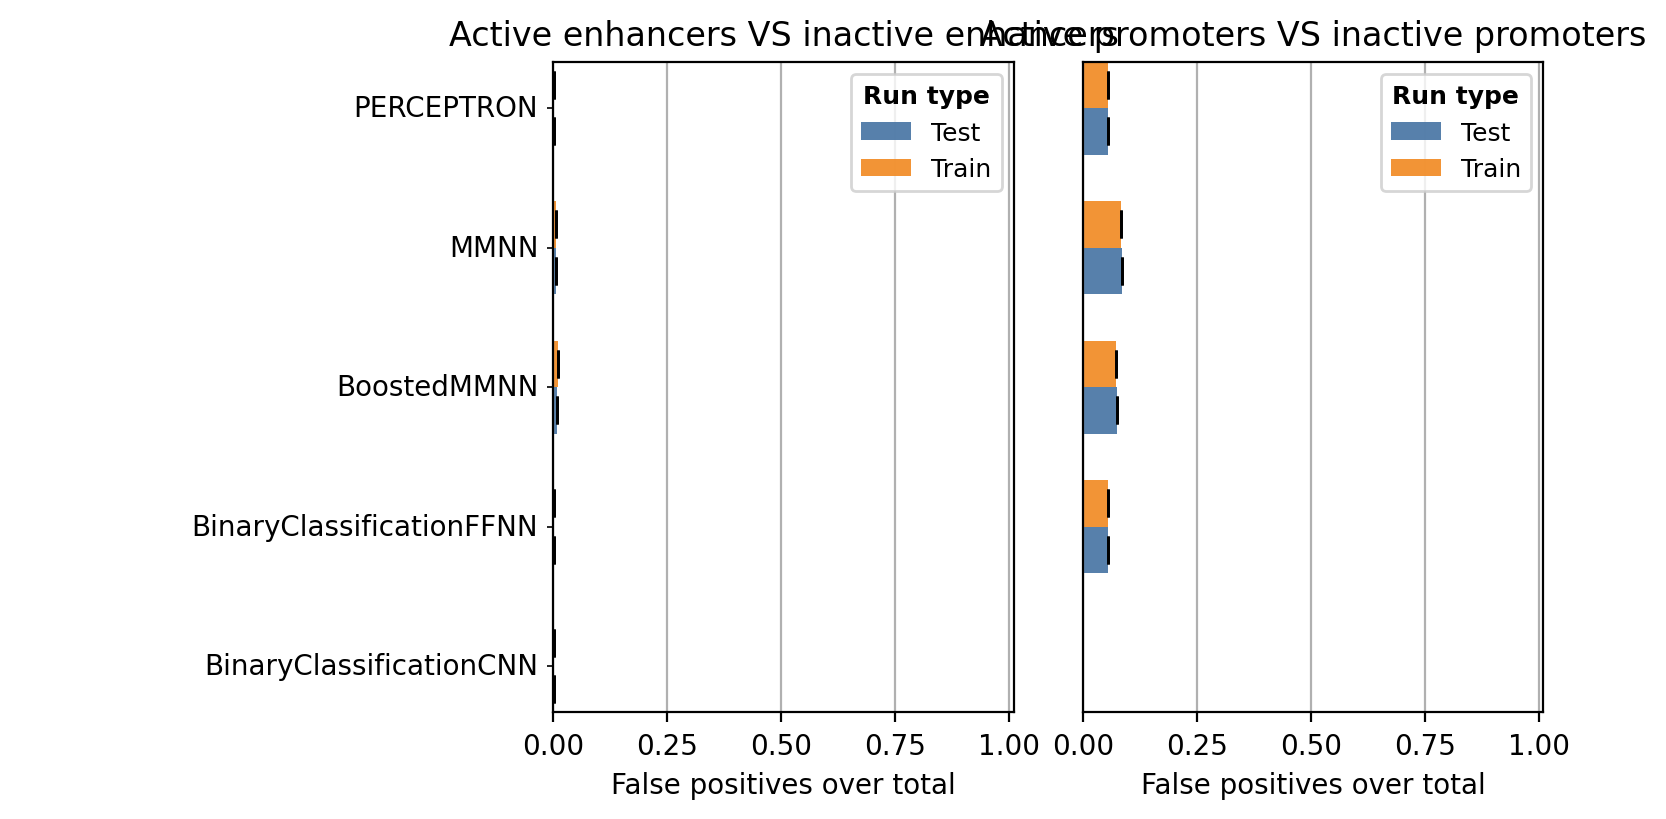

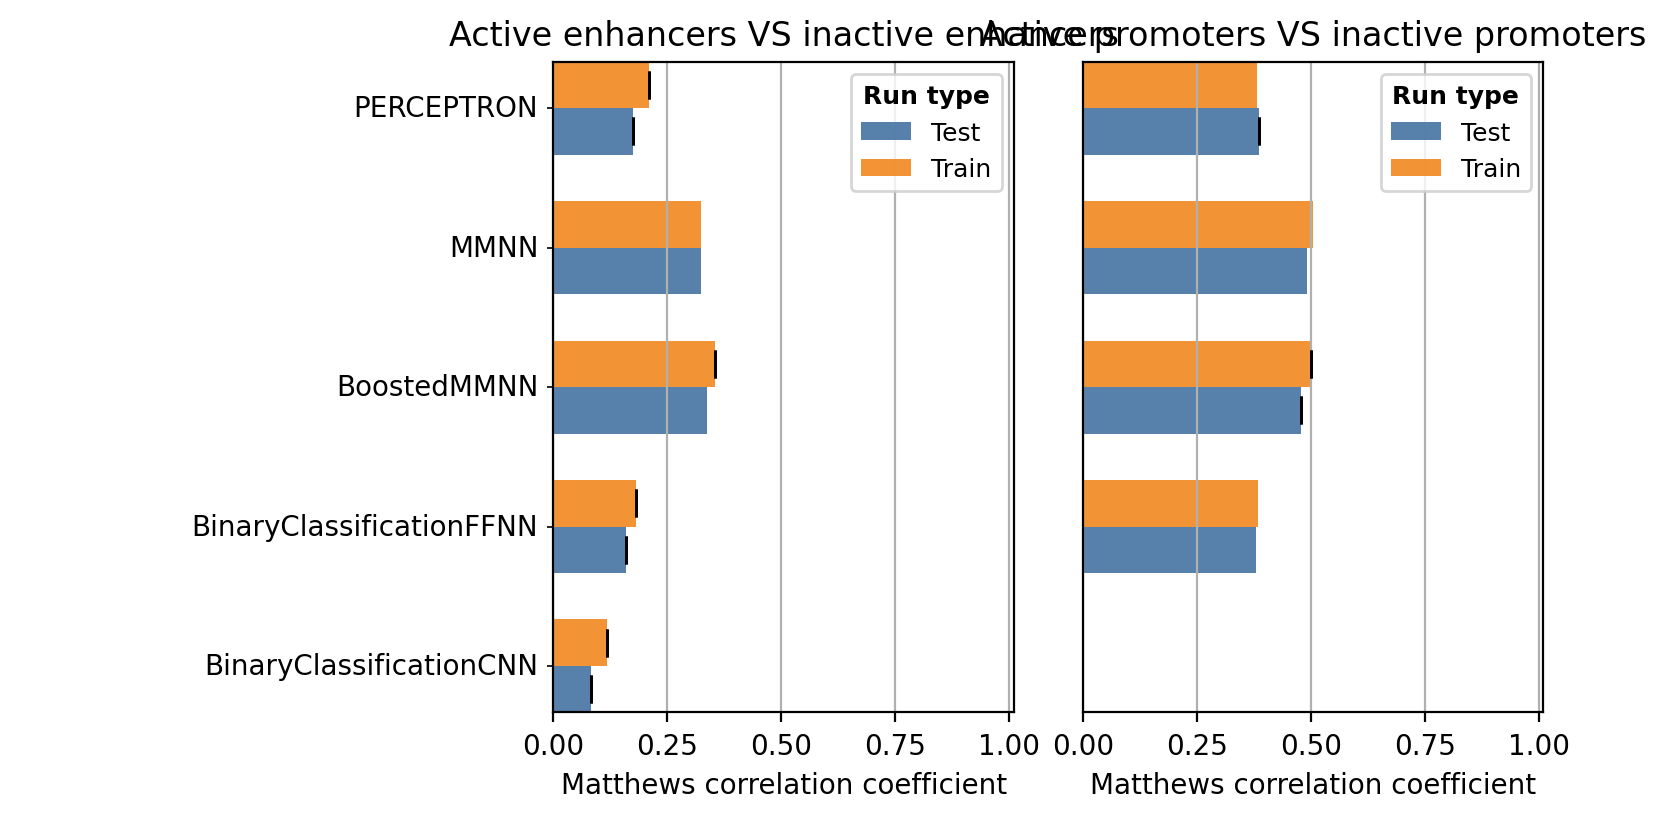

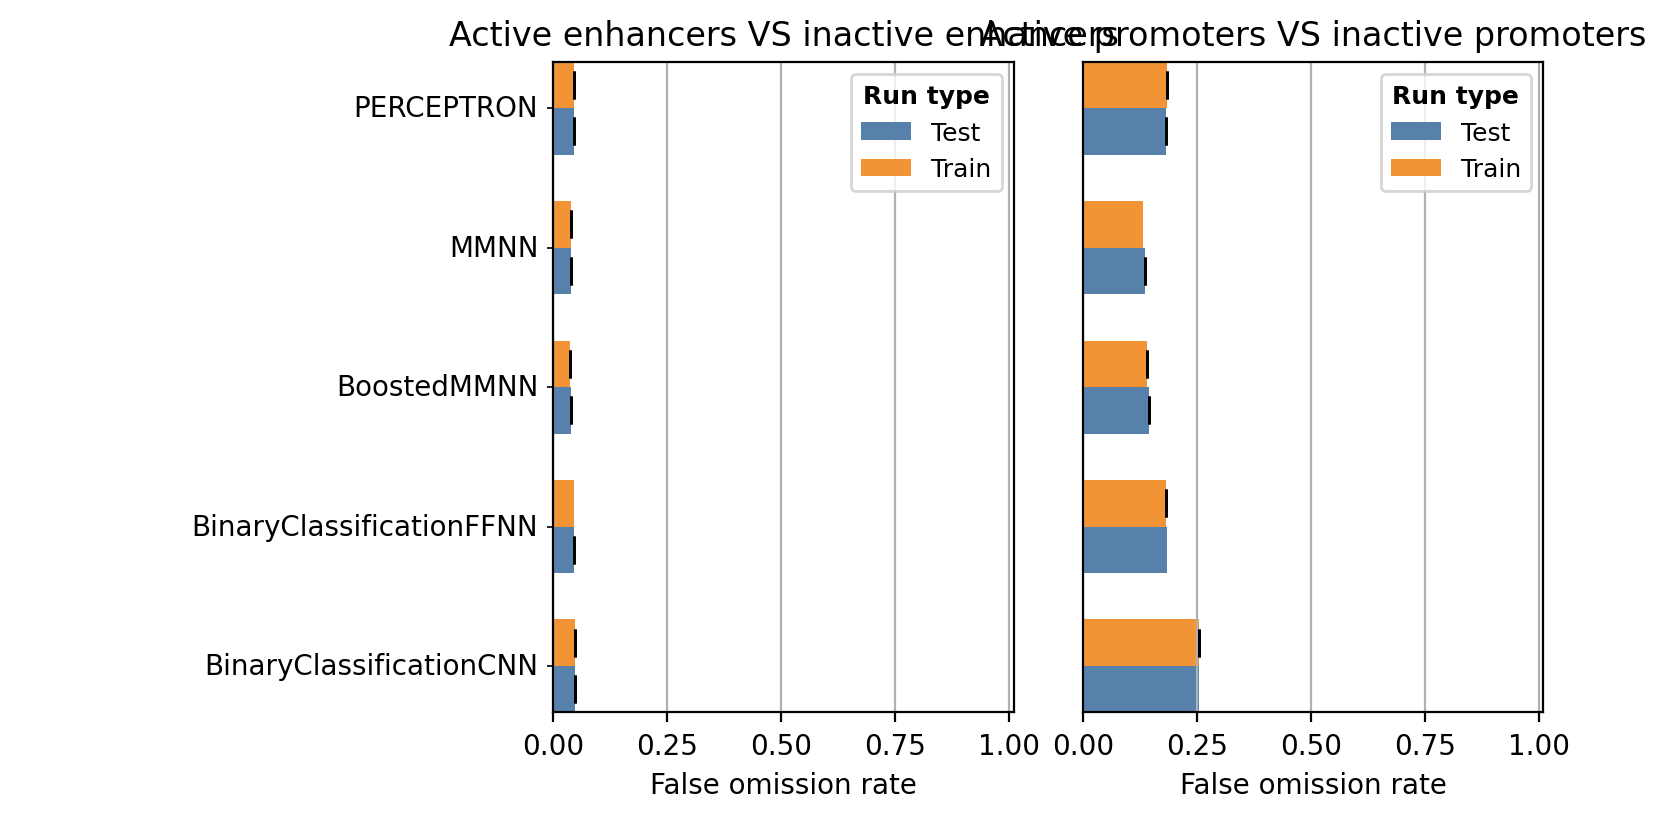

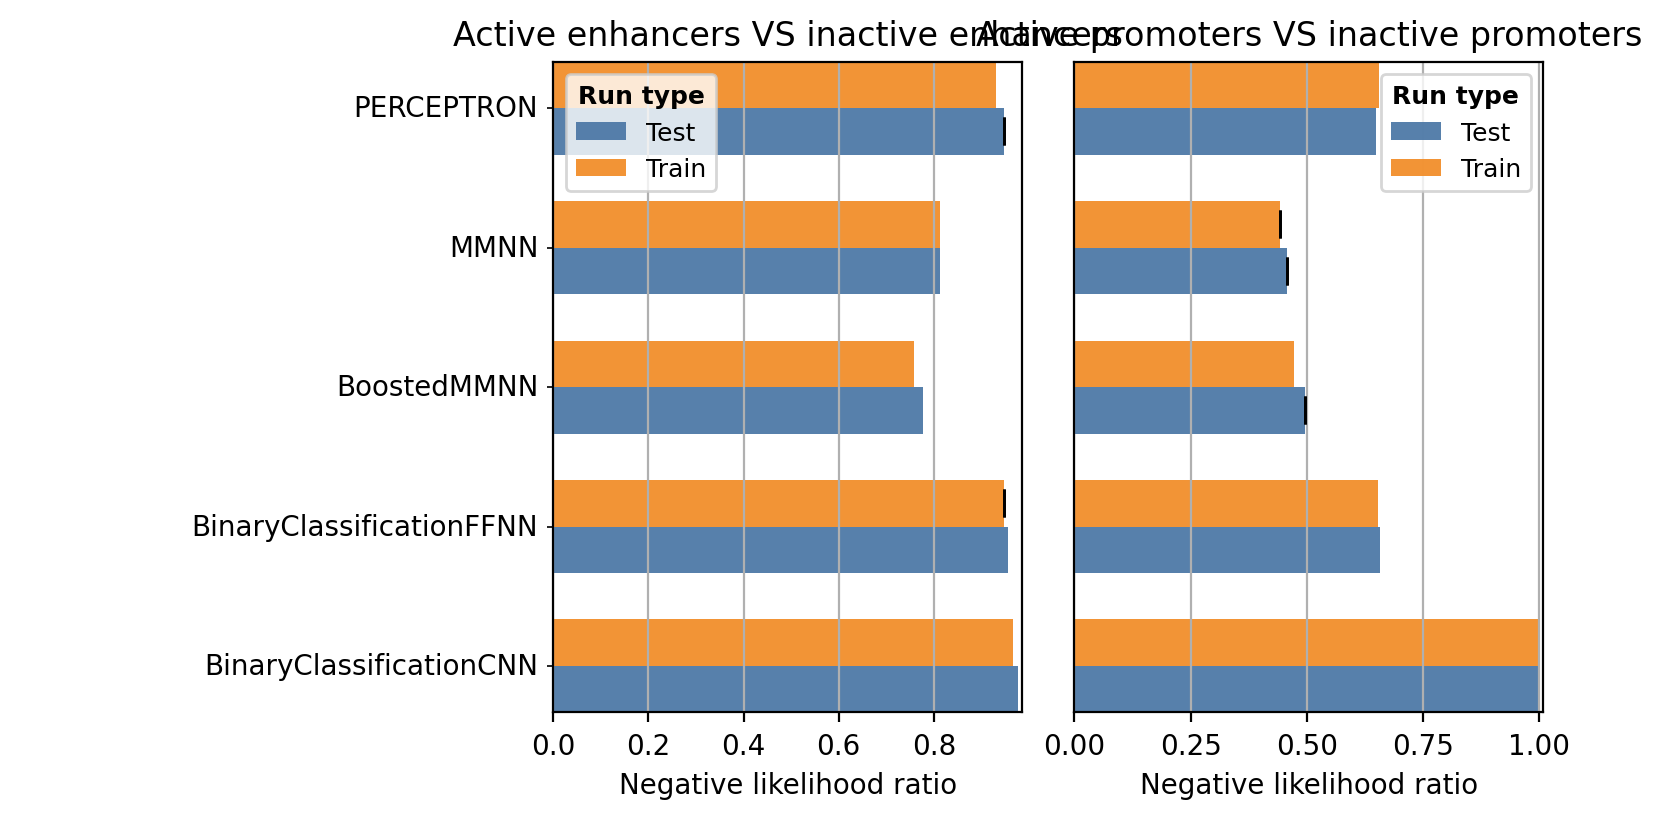

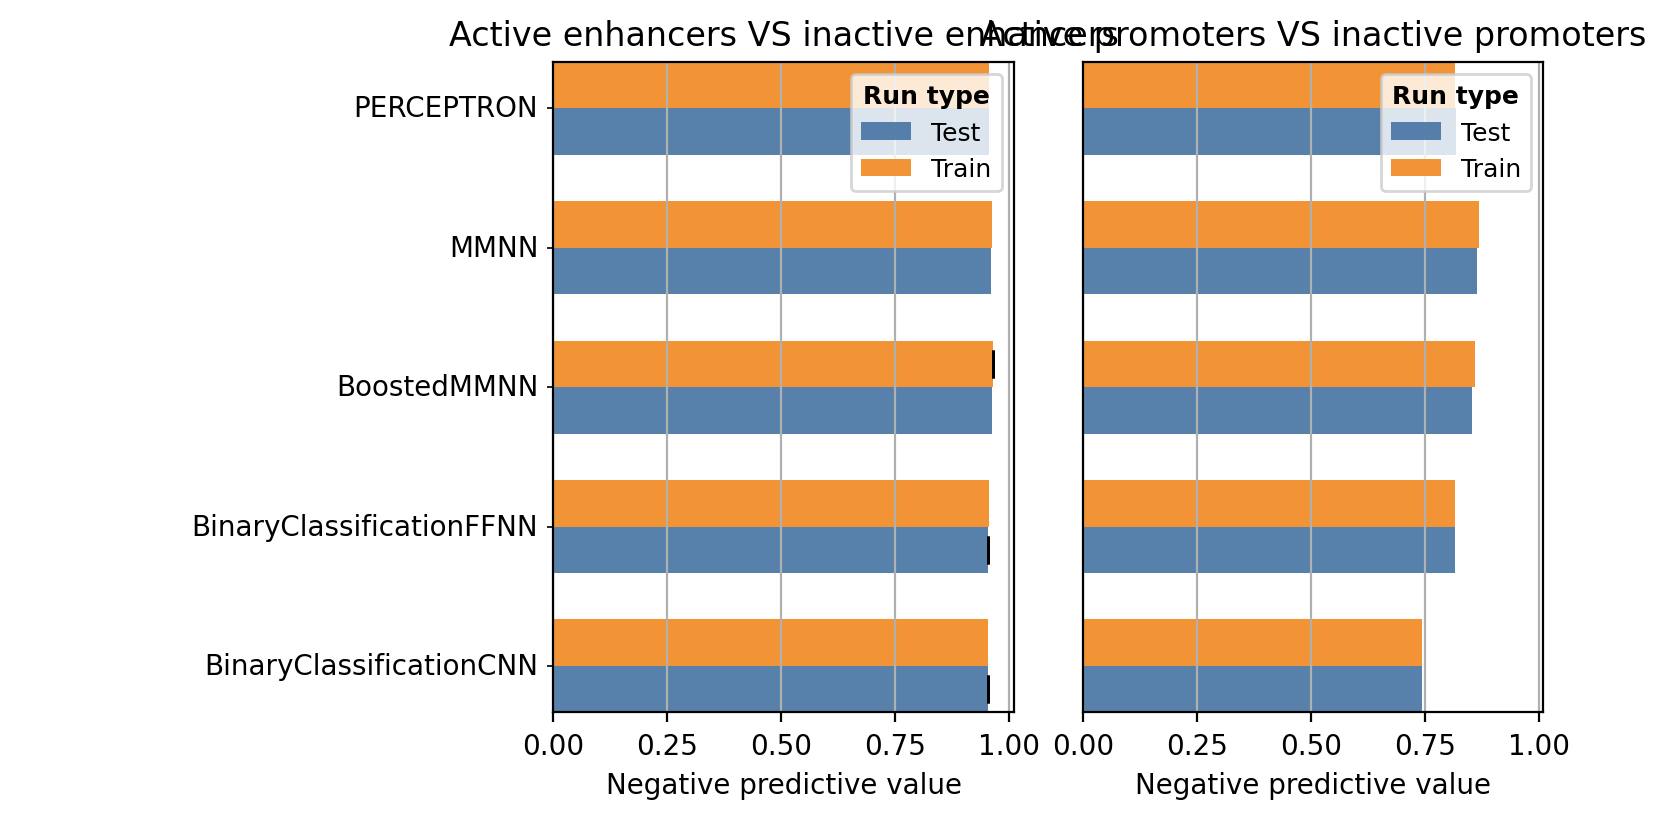

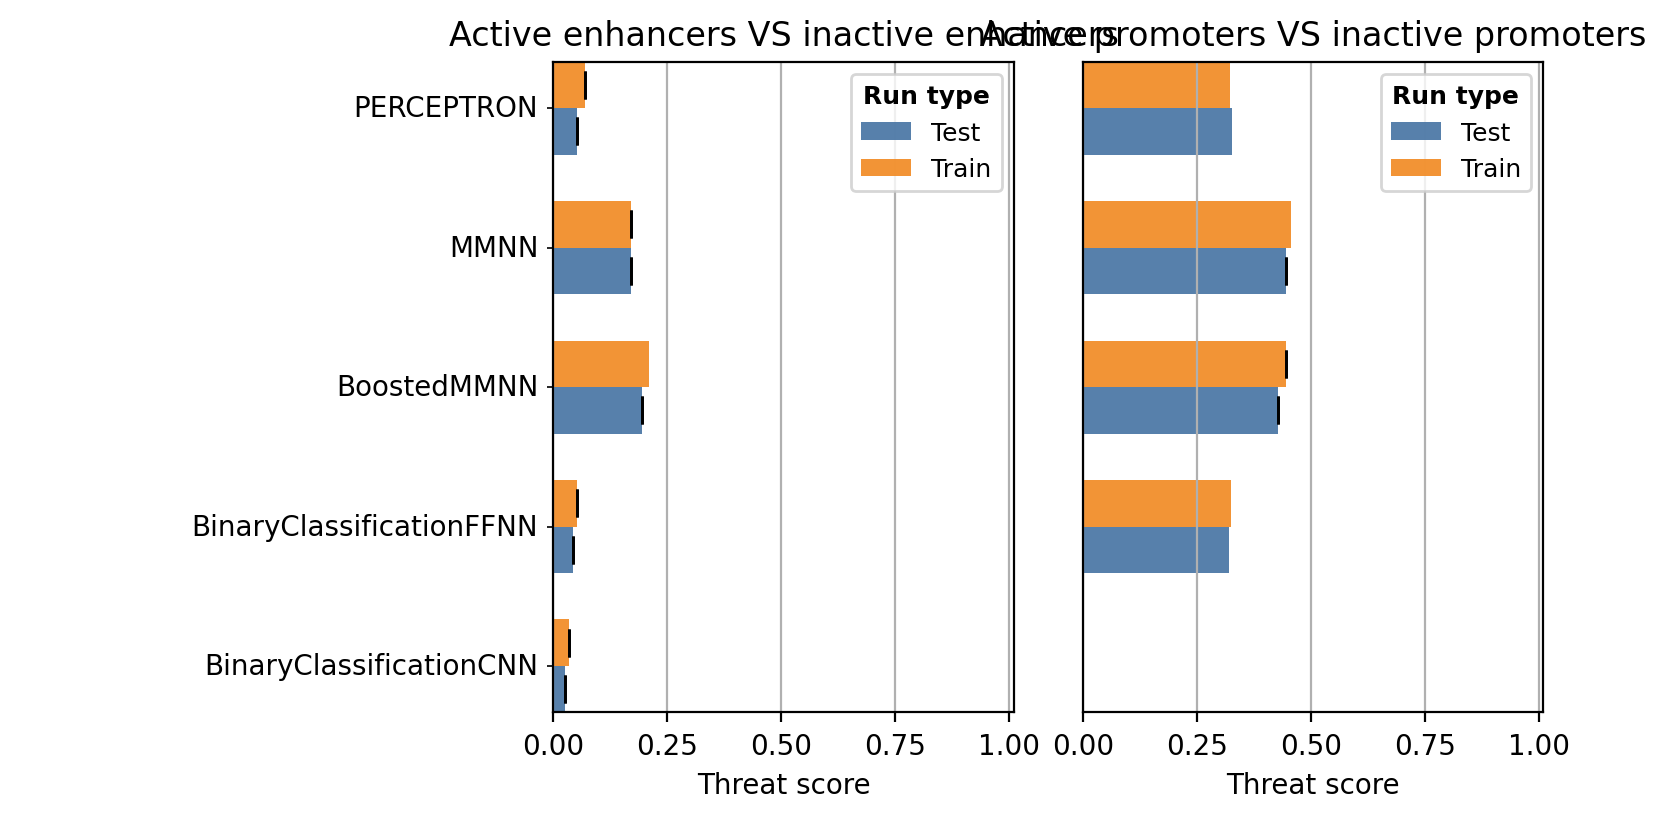

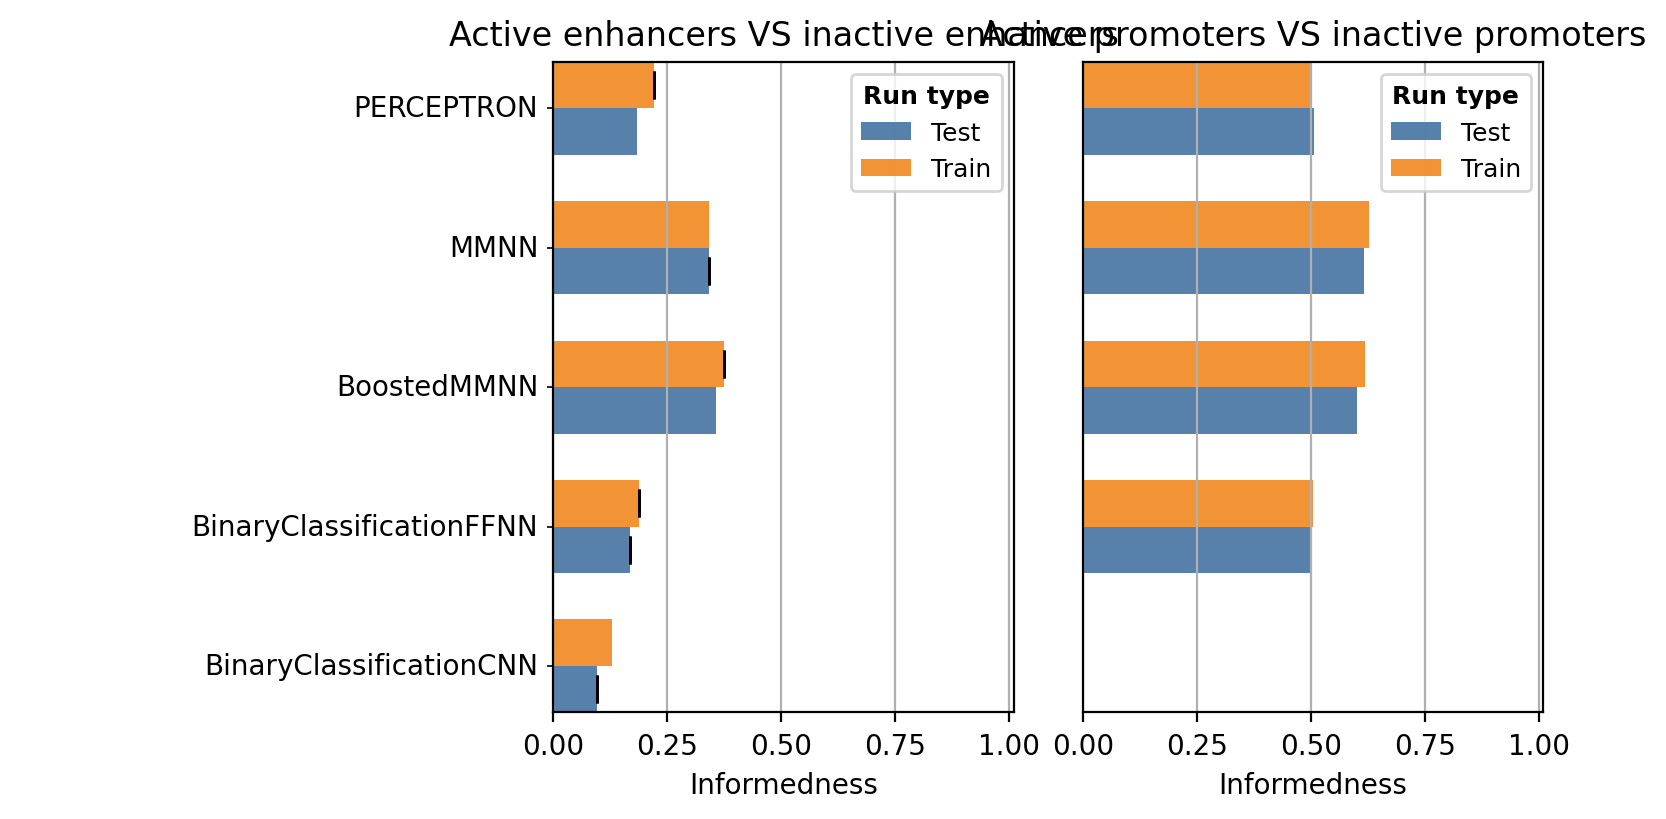

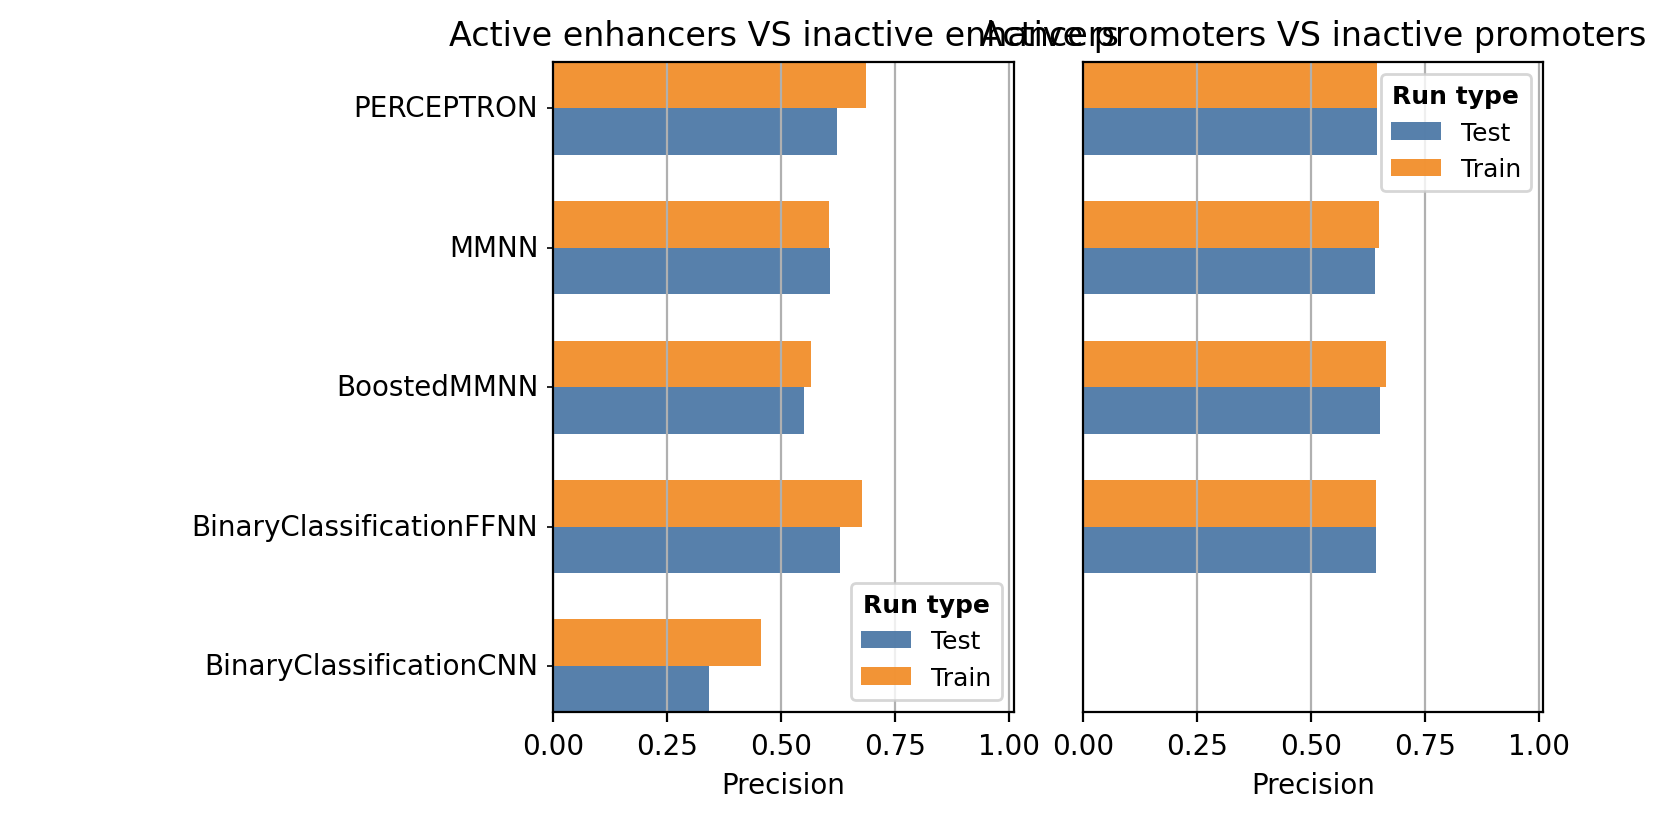

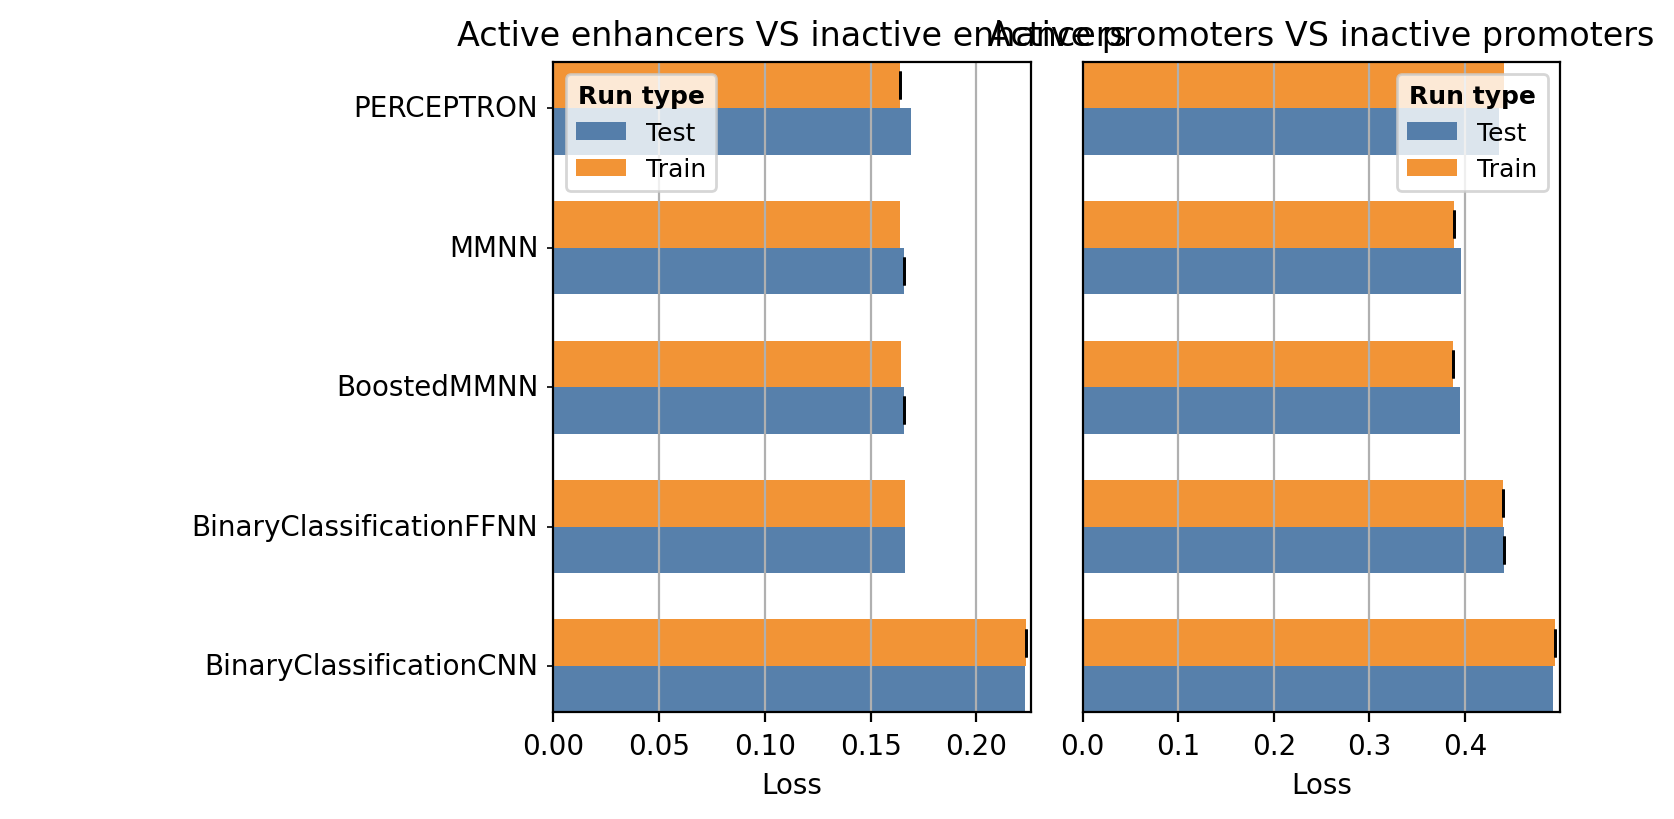

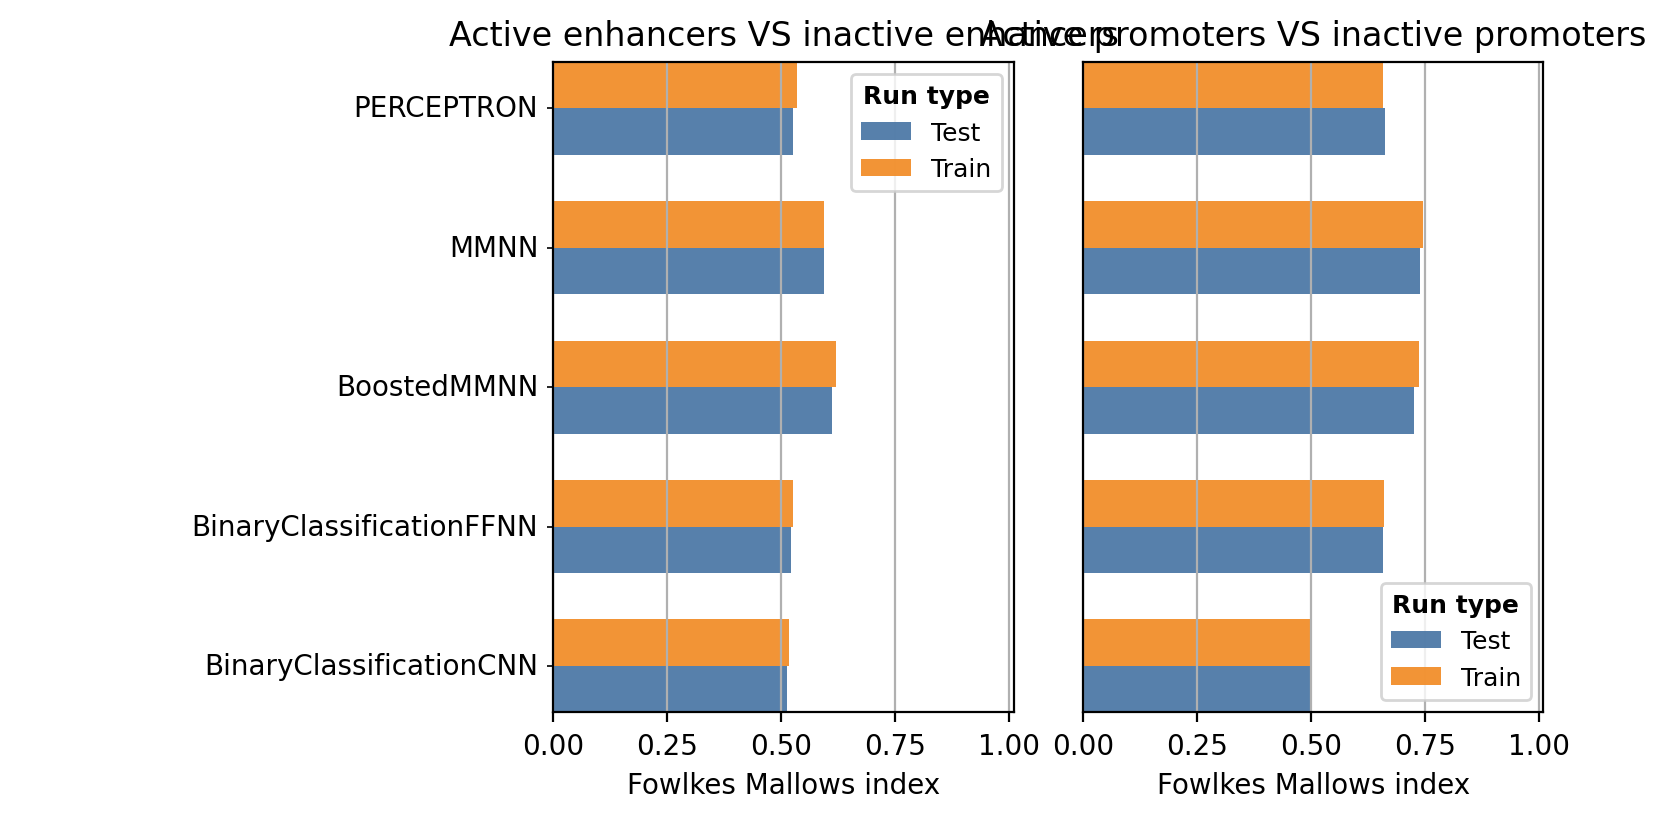

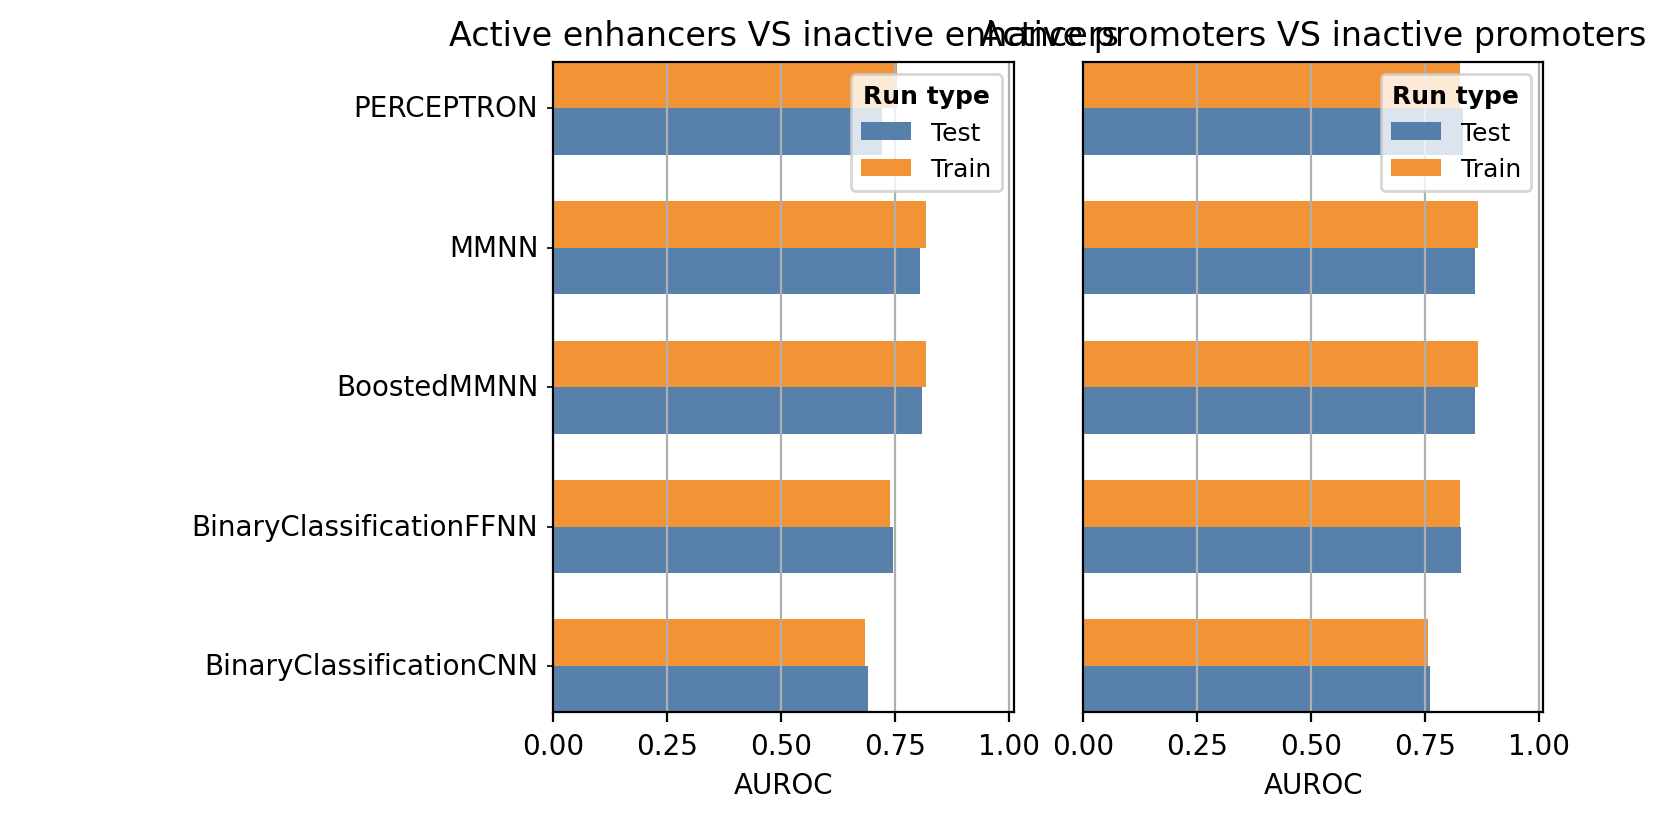

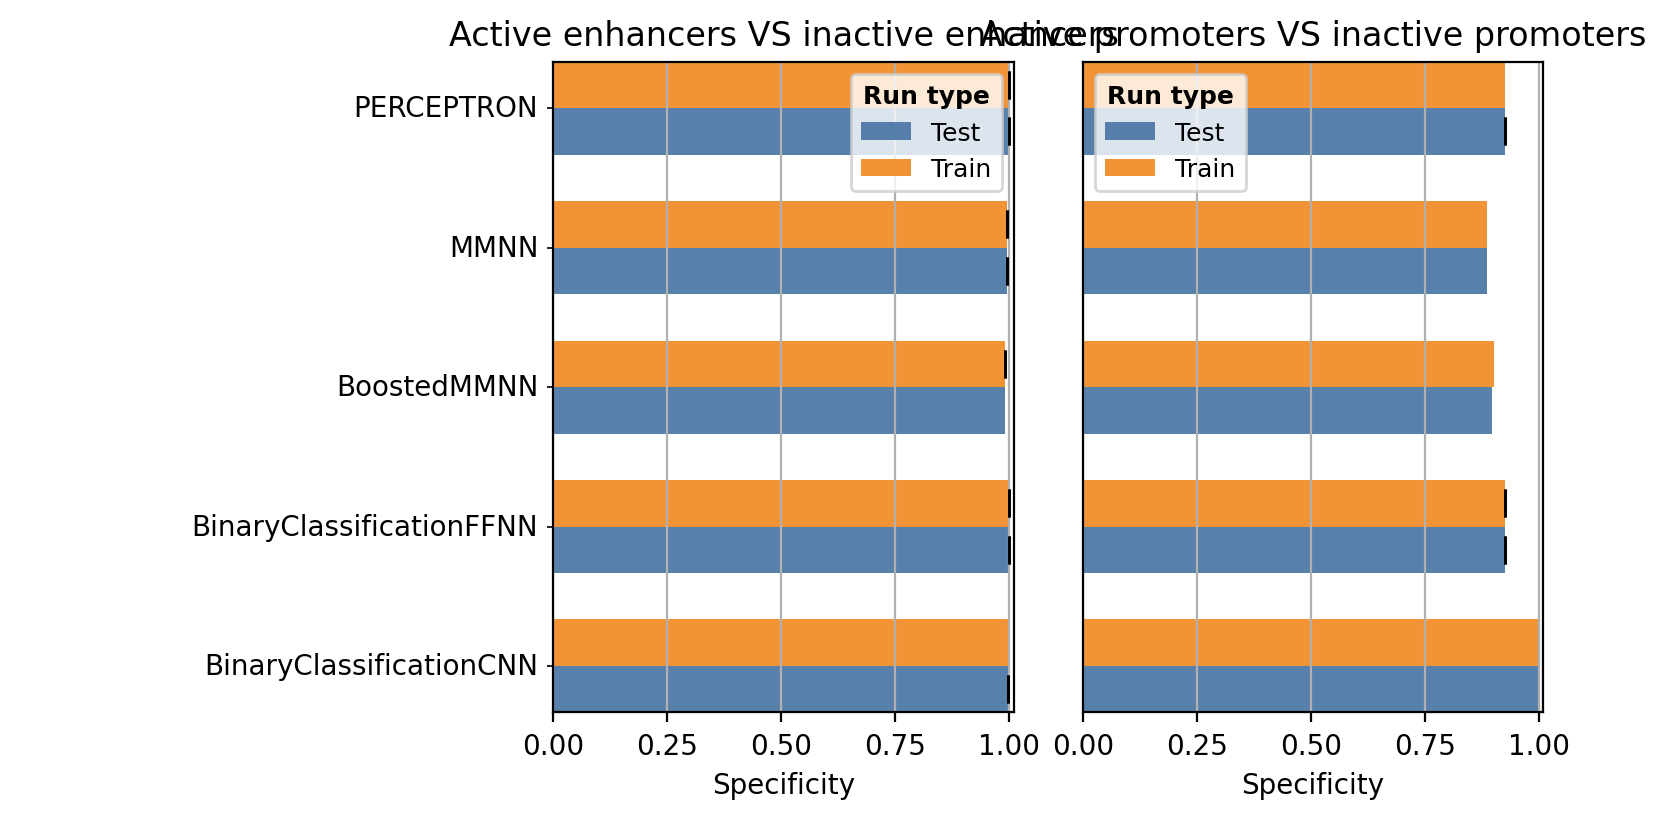

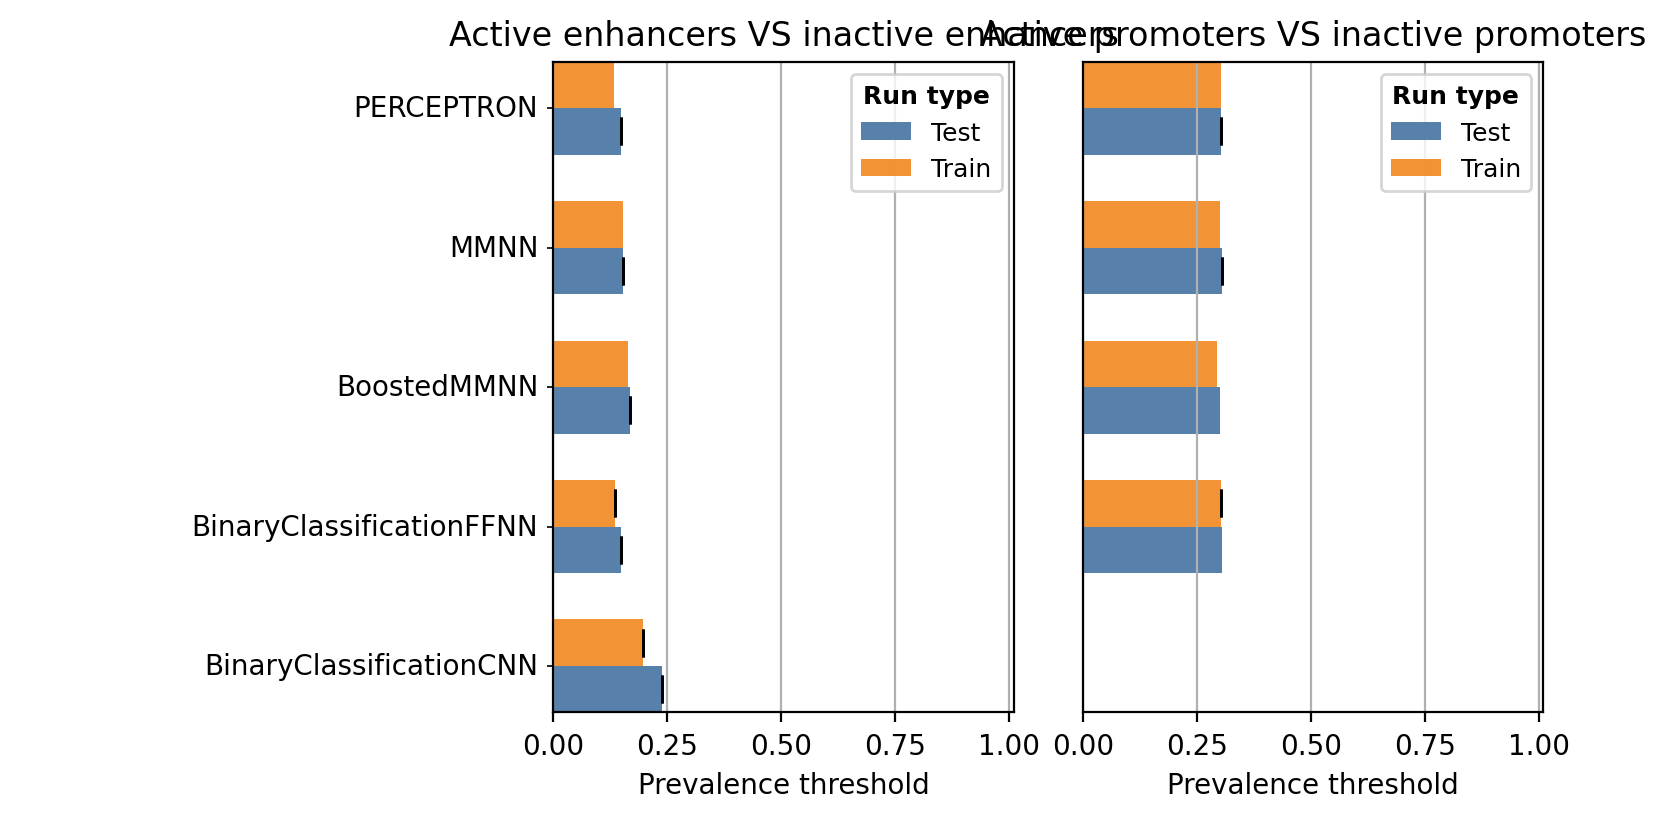

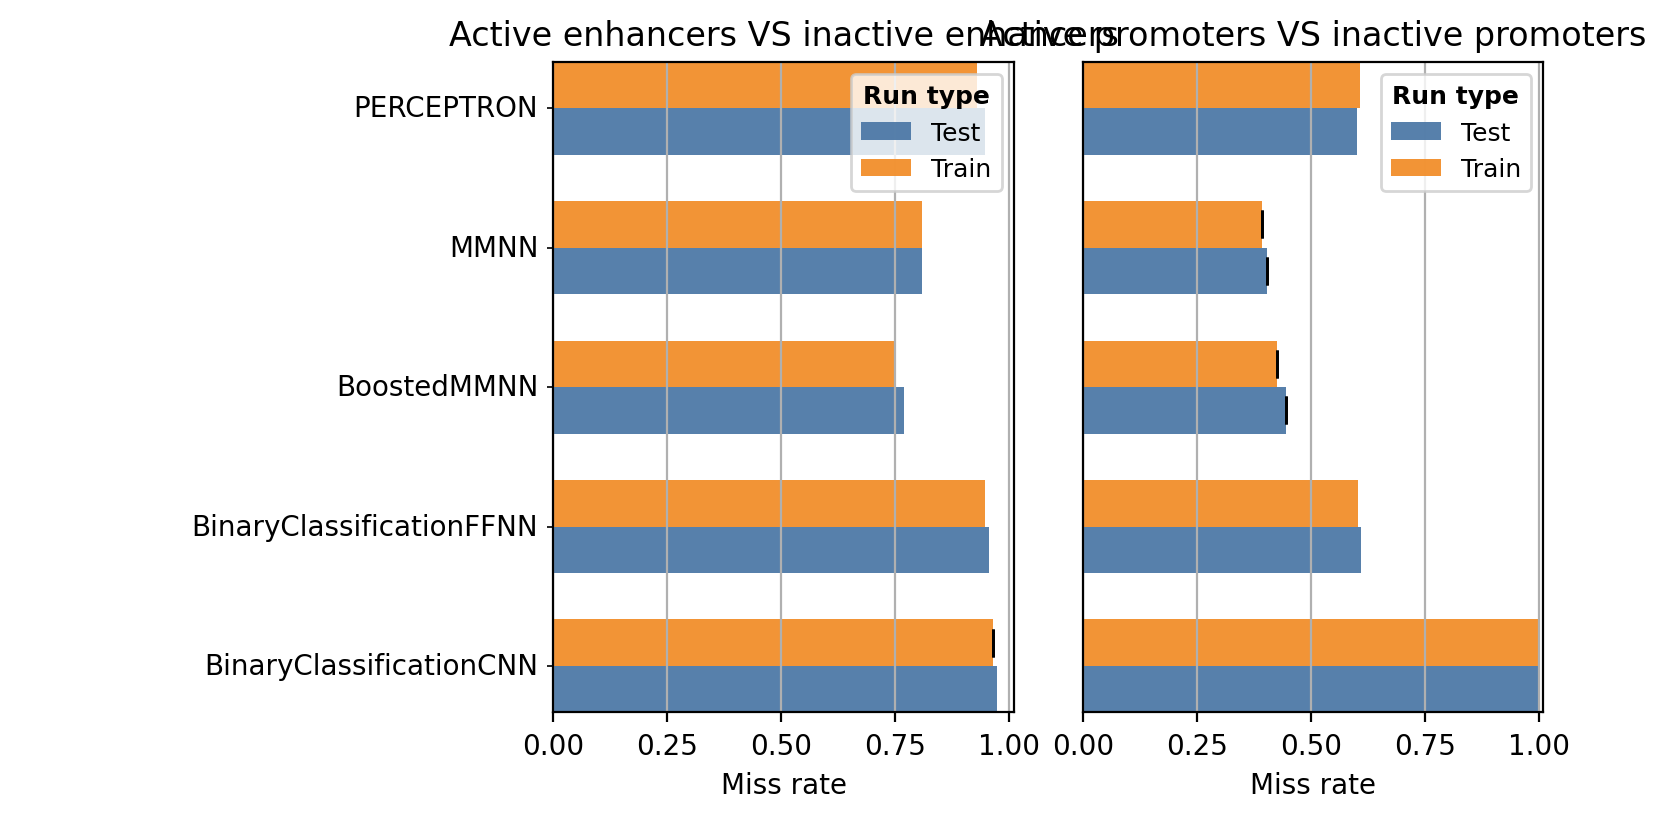

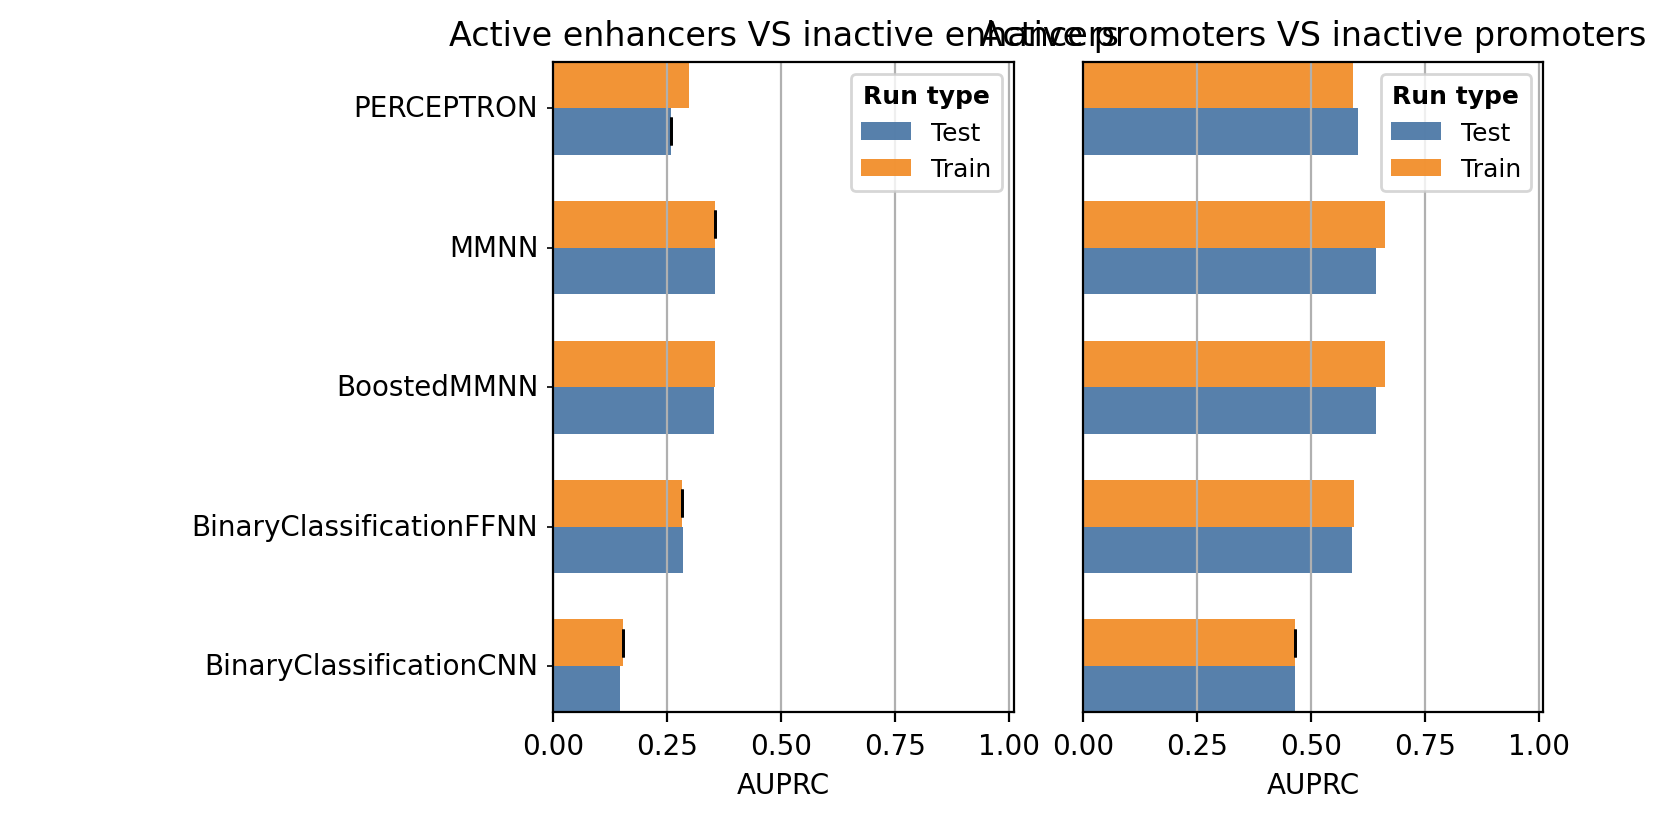

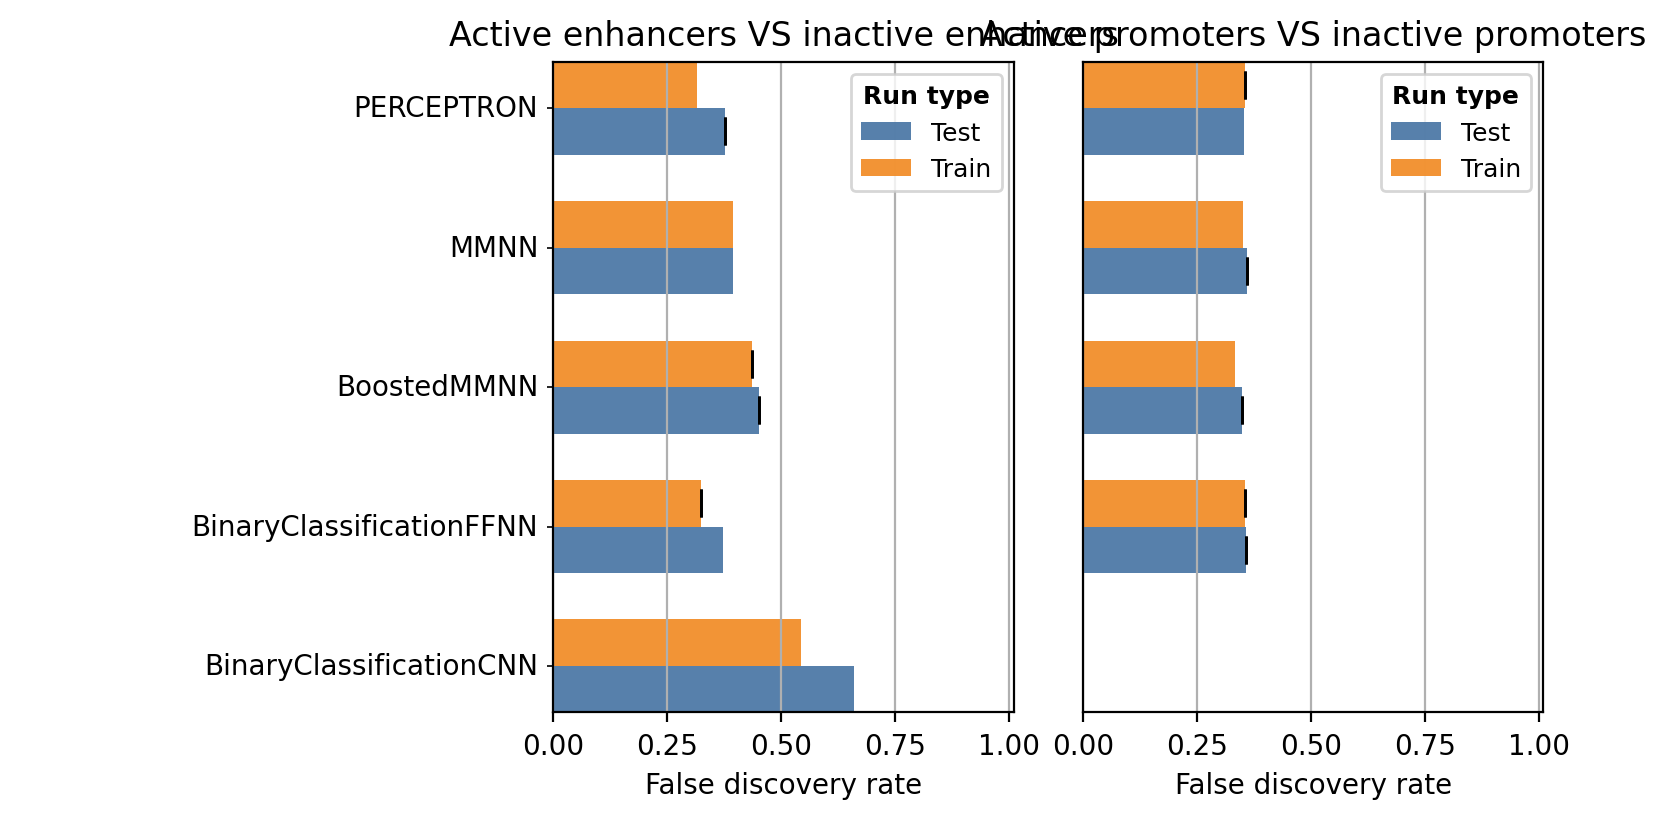

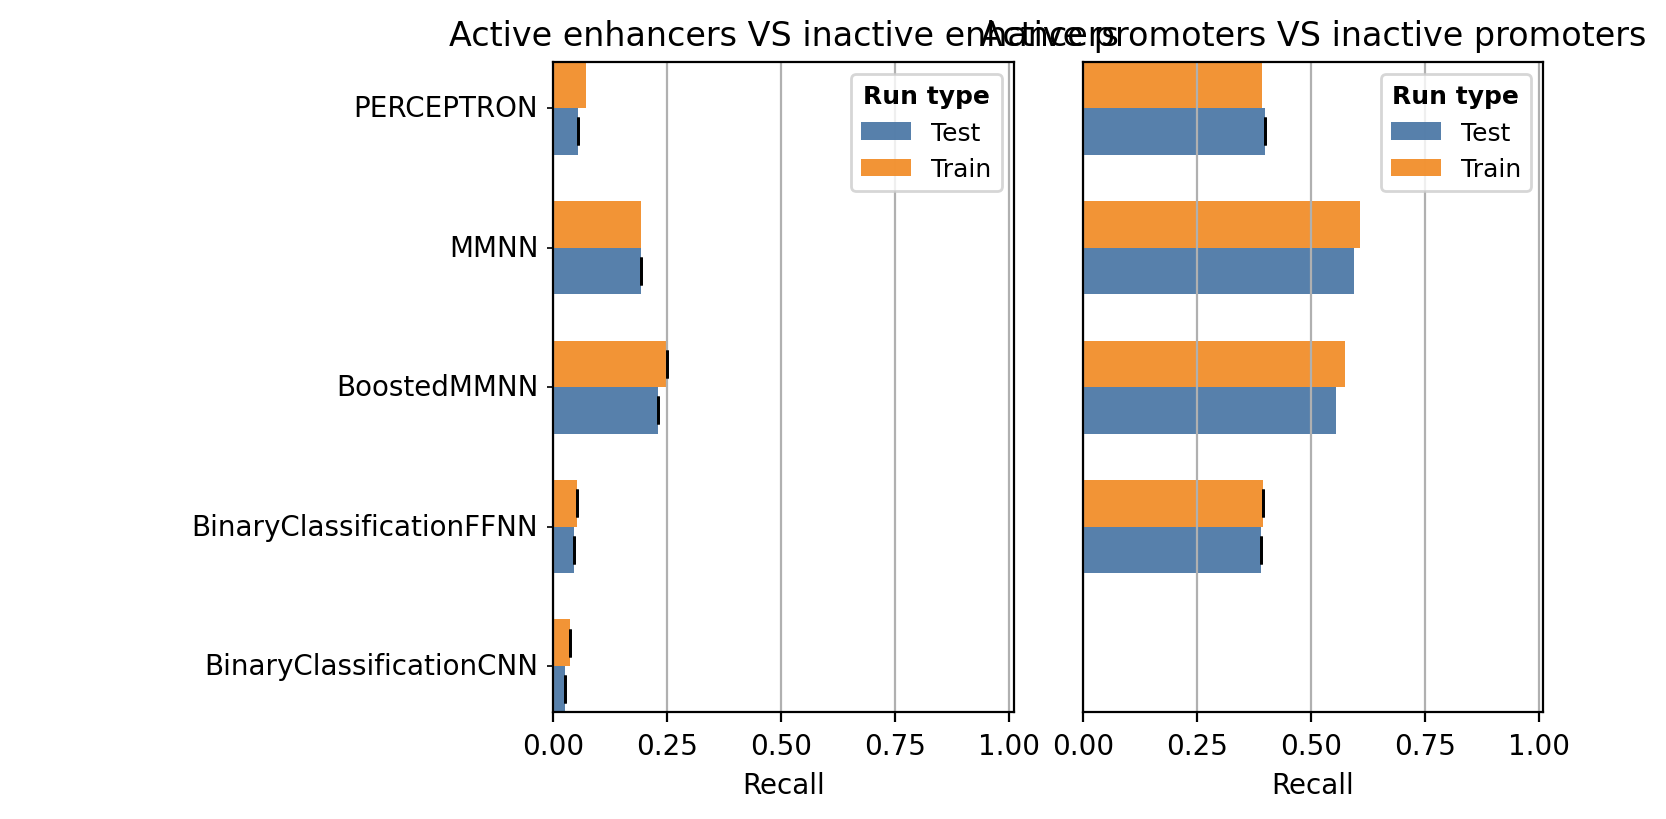

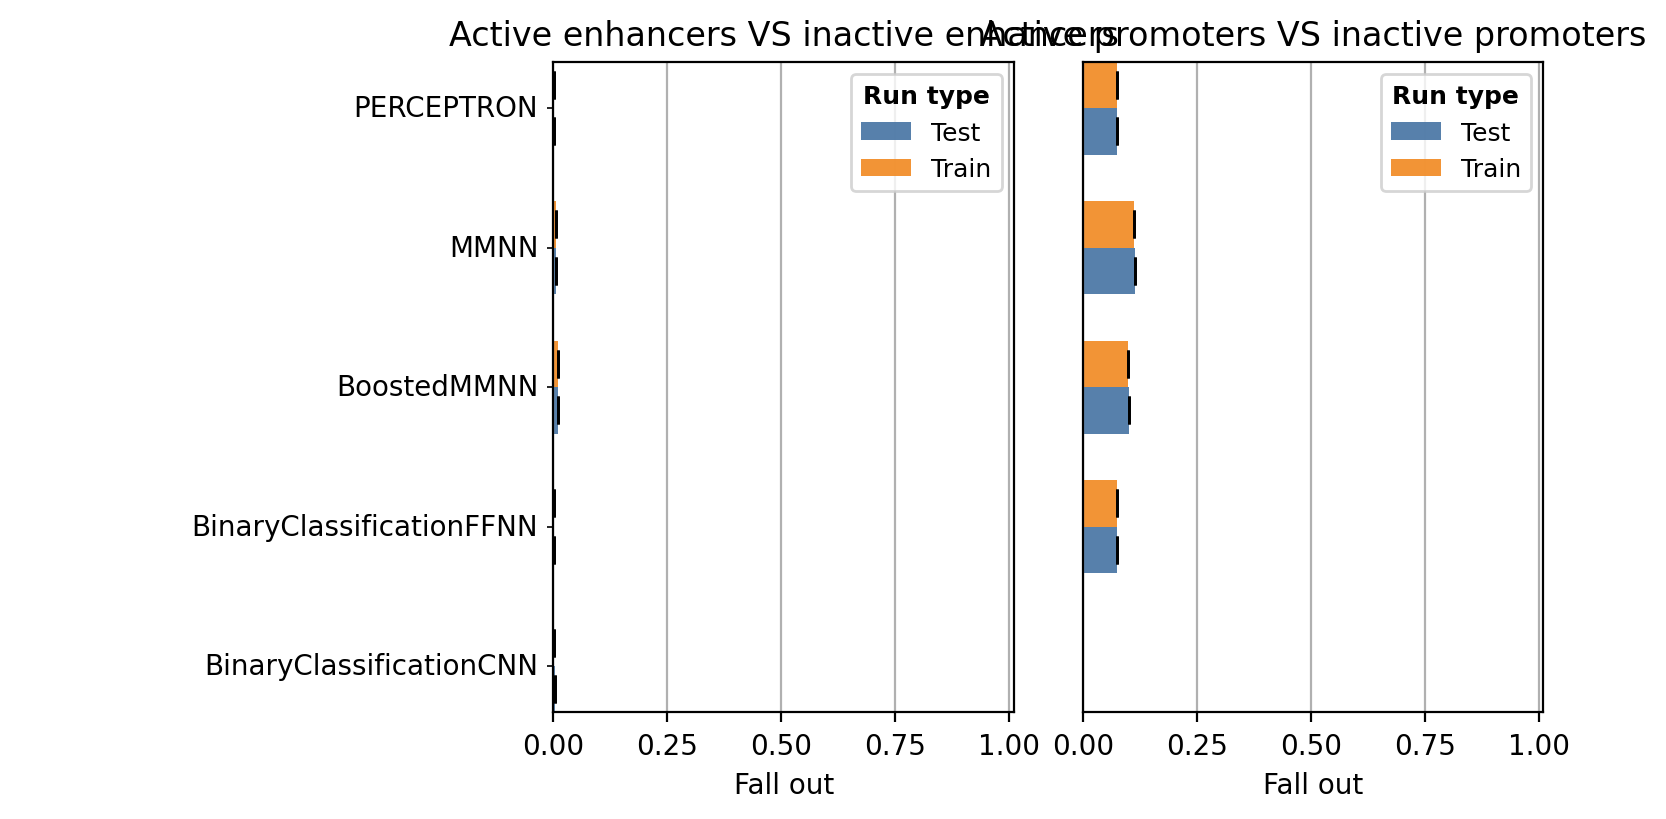

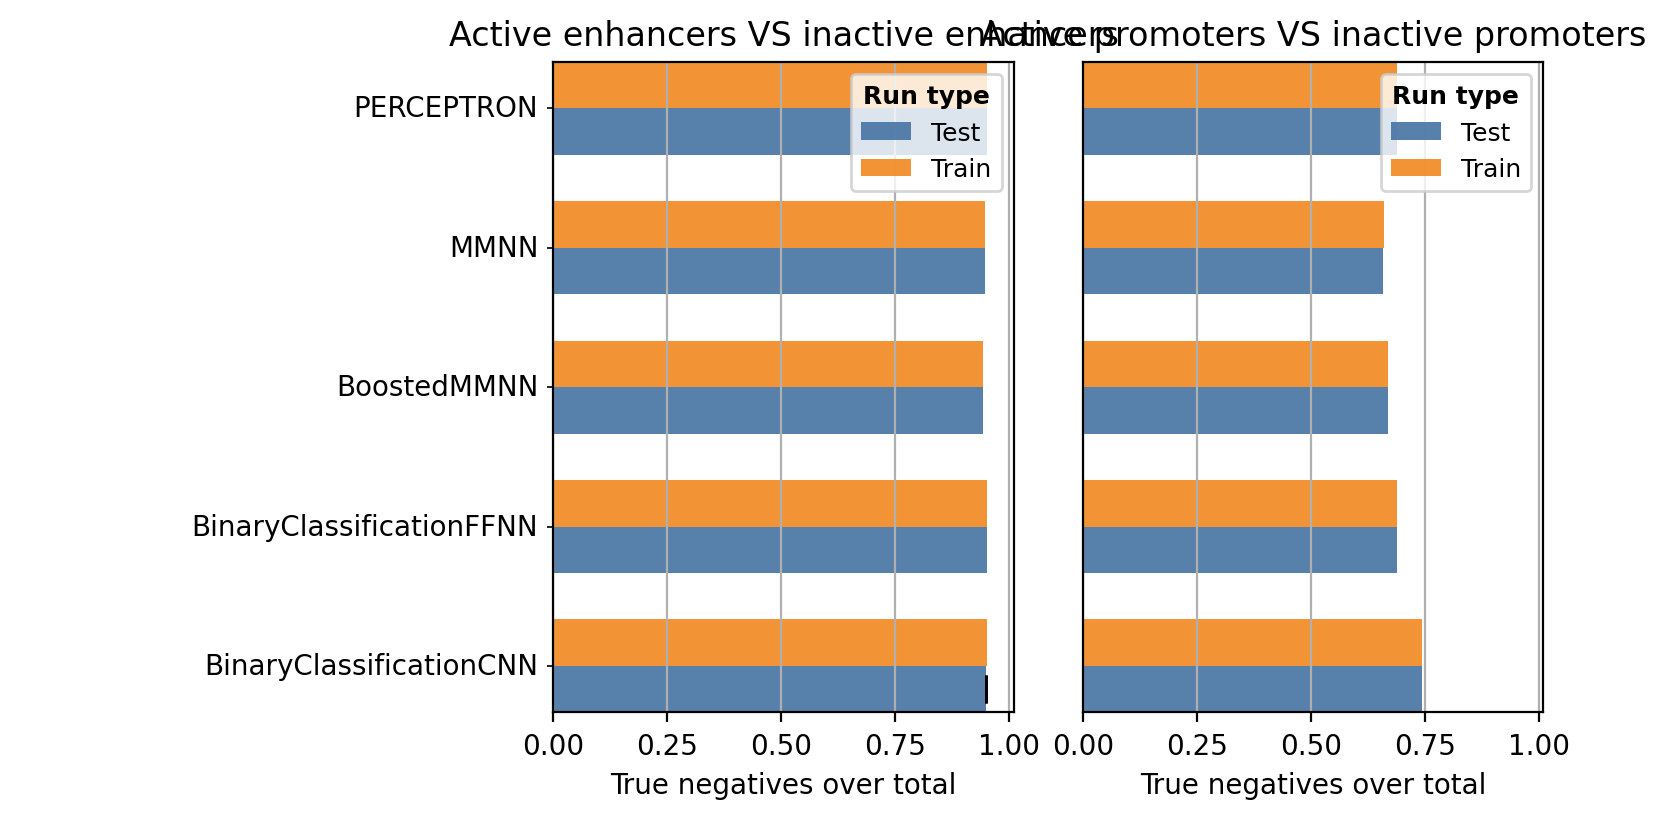

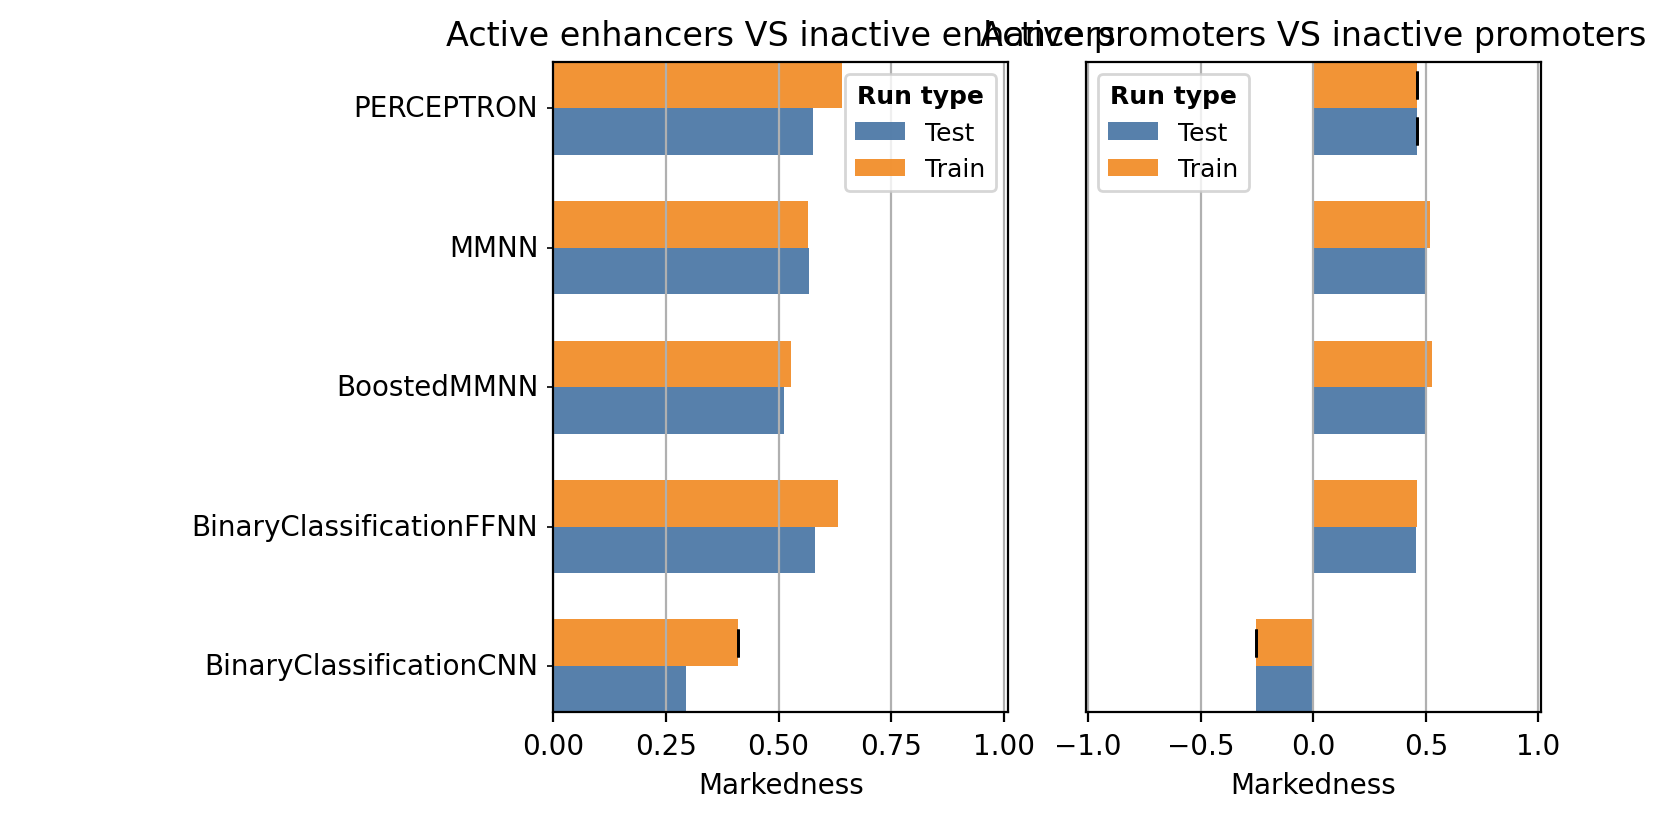

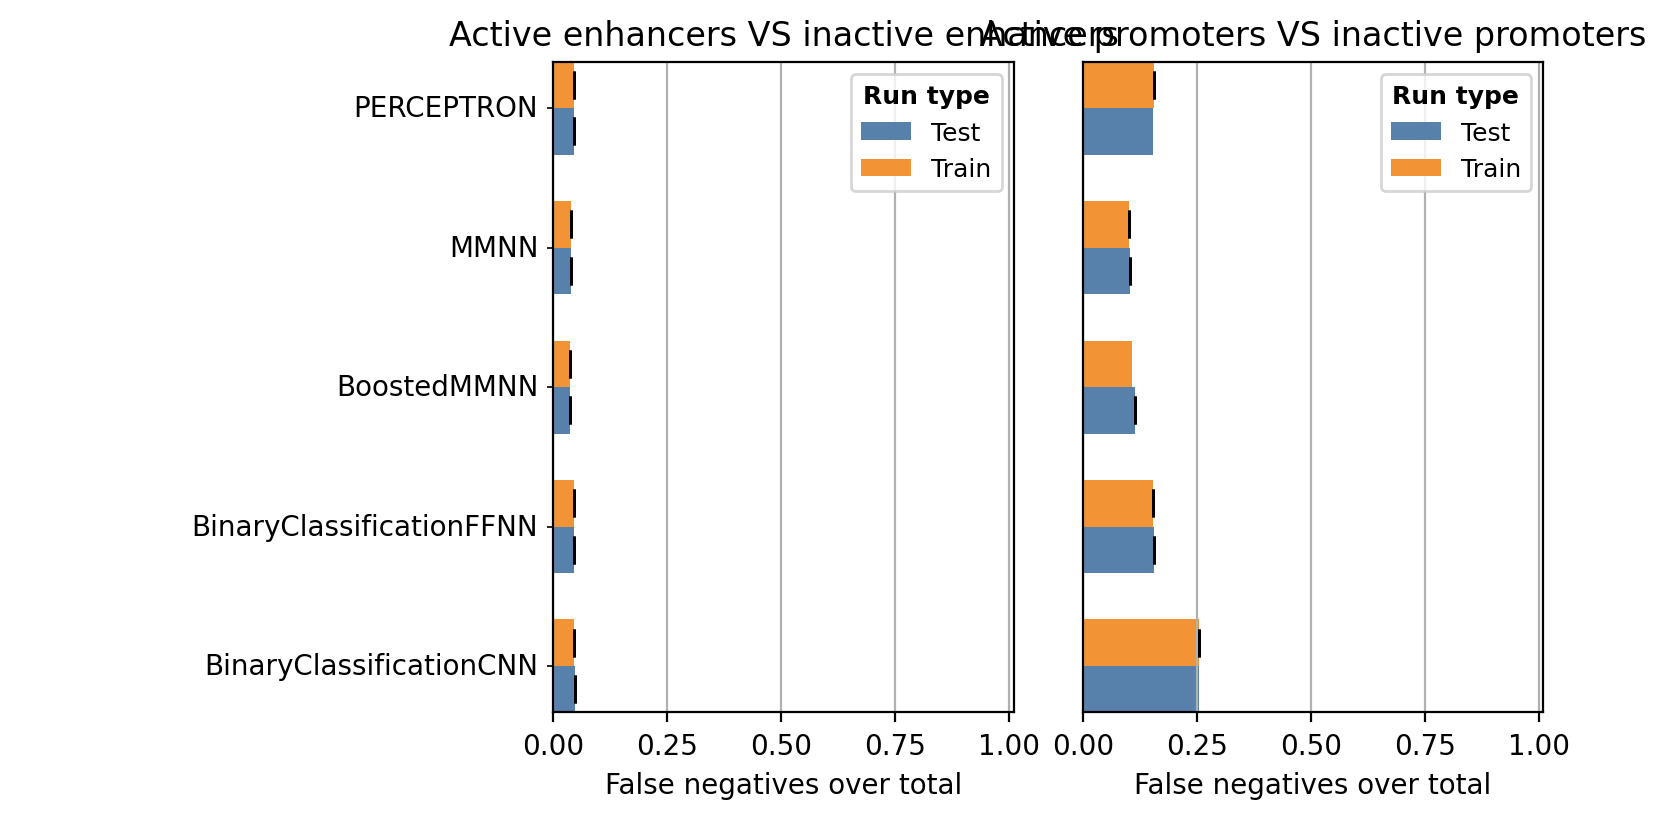

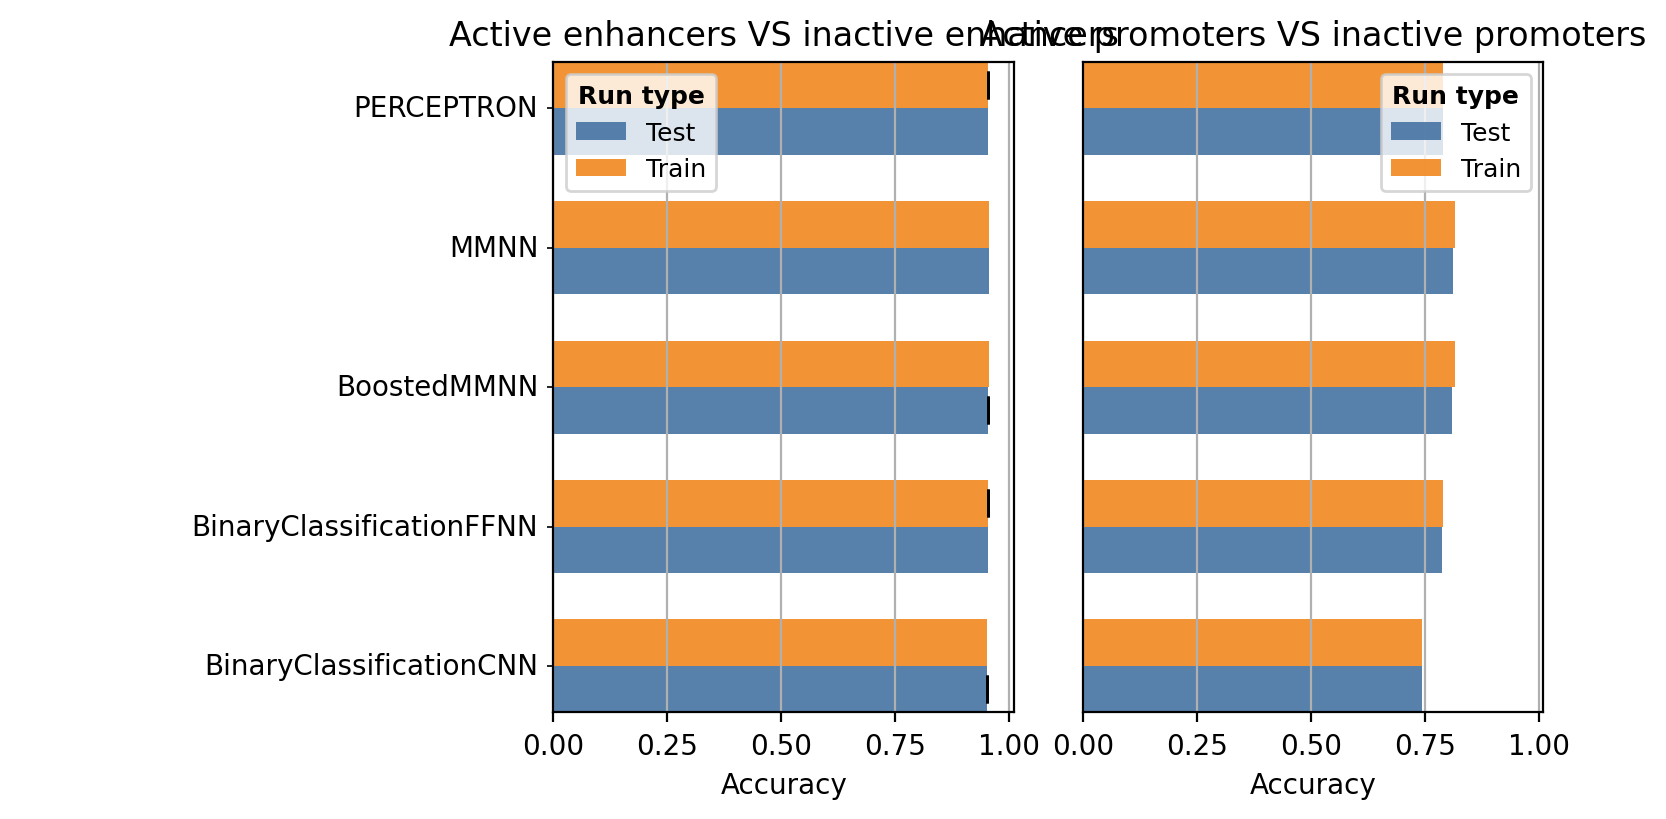

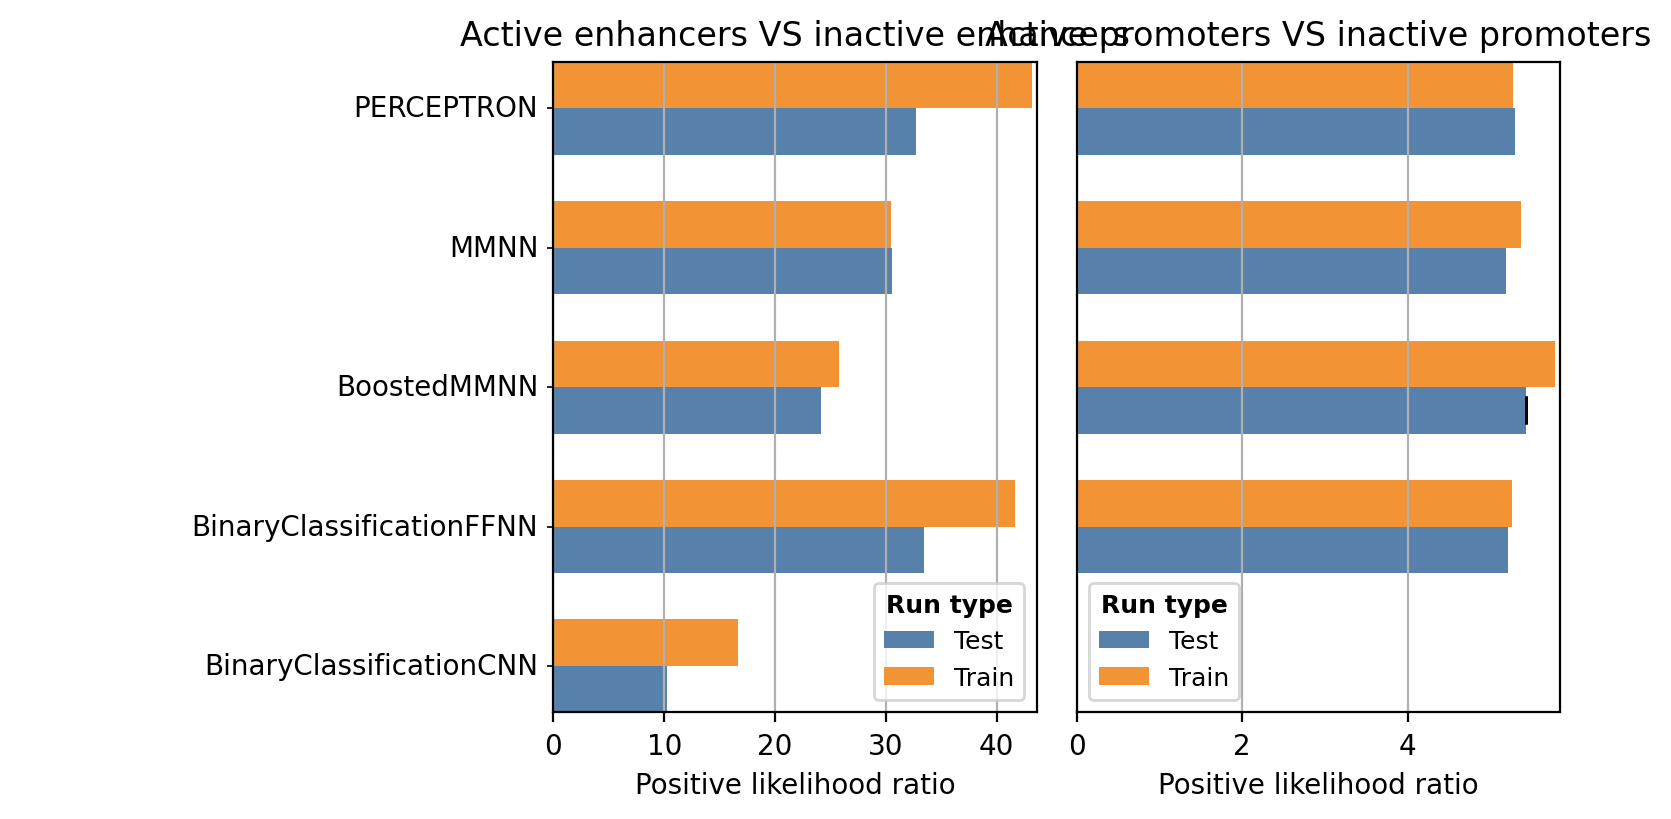

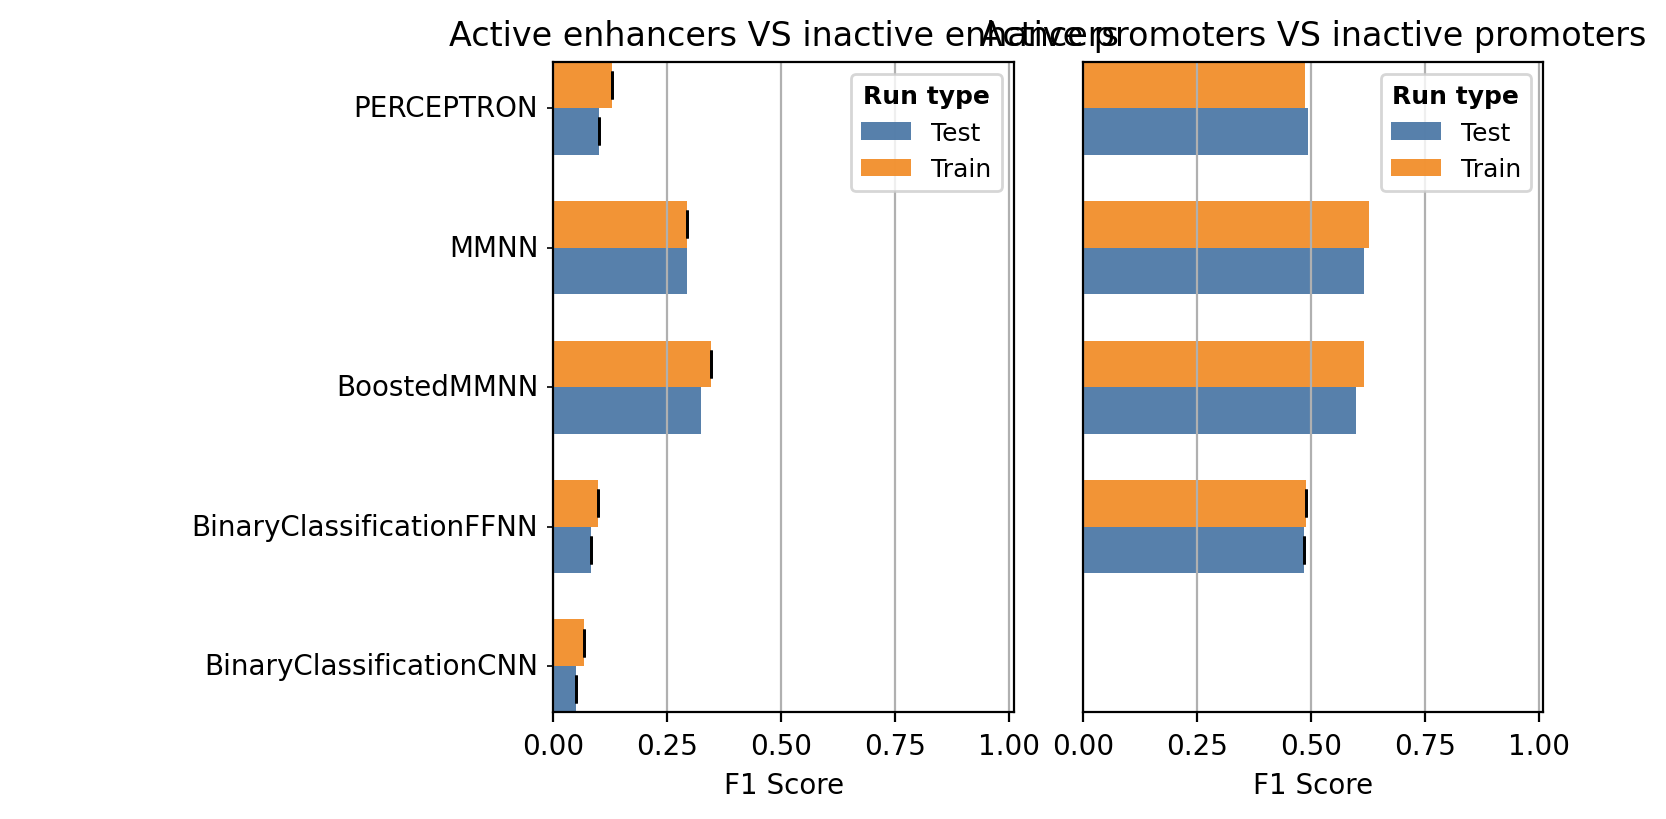

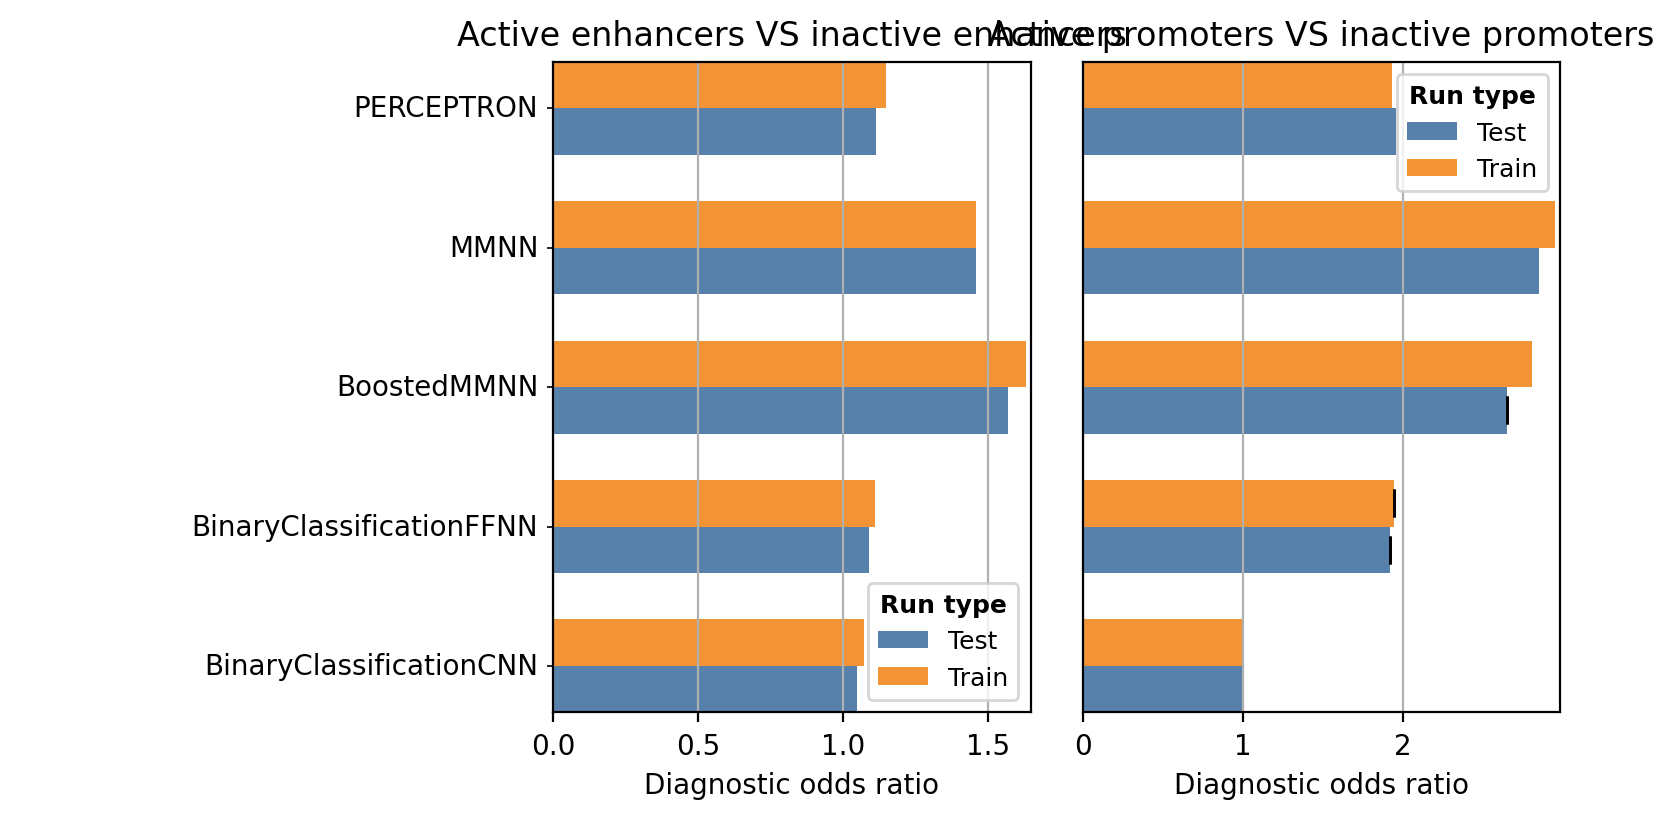

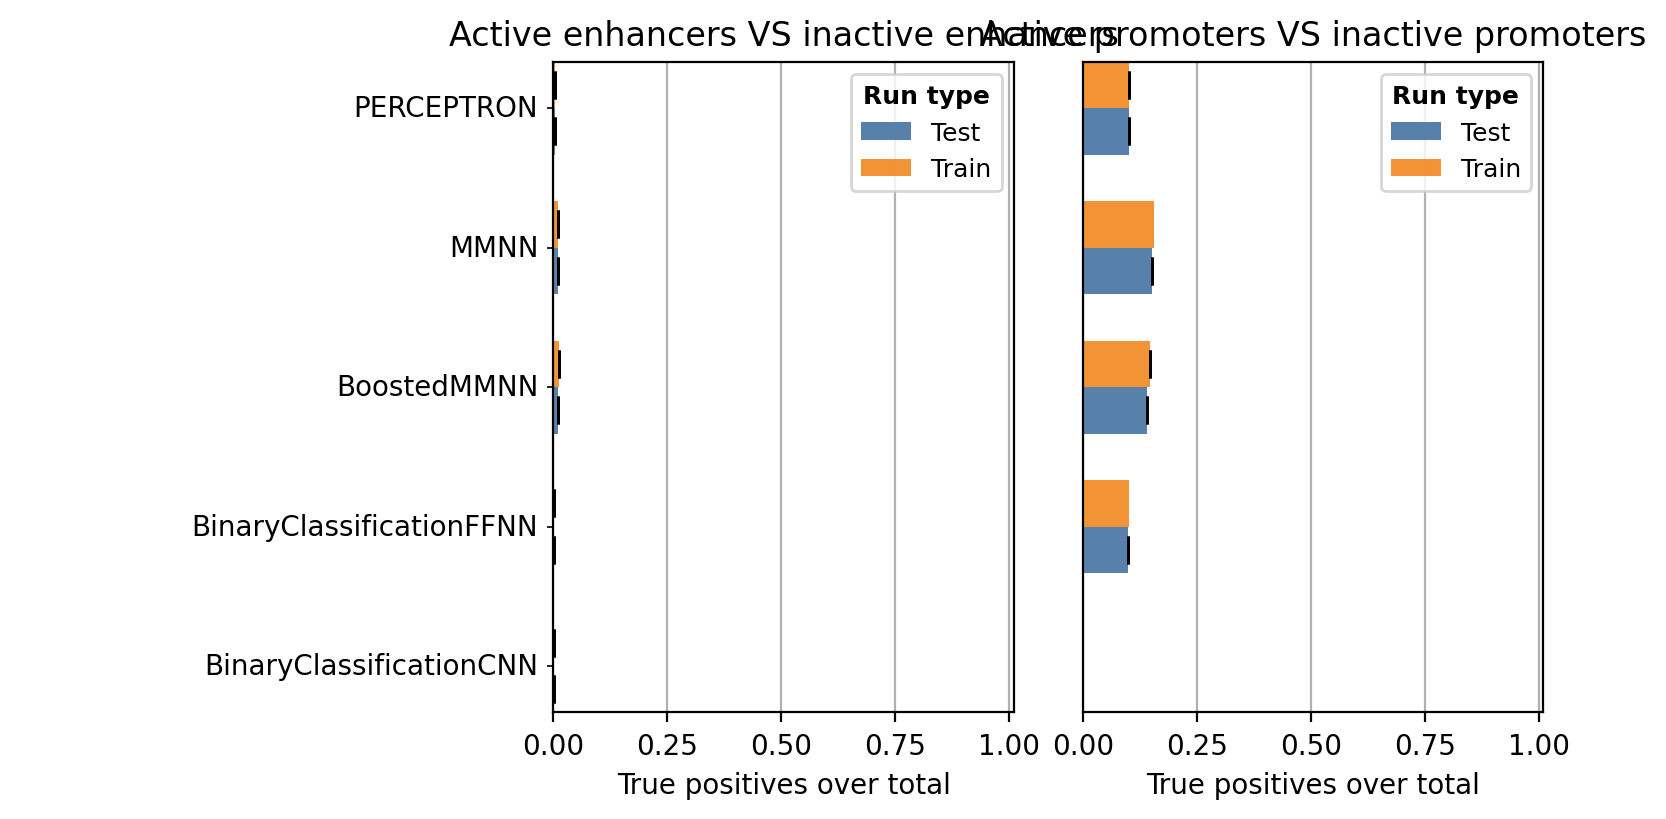

In [ ]:
from barplots import barplots

barplots(
    all_binary_classification_performance_dataframe.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=4,
    subplots=True
)

In [ ]:
all_binary_classification_performance_dataframe

loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.163832  0.953840  0.070782   0.685259  0.753097  0.298242  0.128310   
1  0.169202  0.952990  0.054276   0.622642  0.721503  0.257965  0.099849   
0  0.163832  0.953840  0.070782   0.685259  0.753097  0.298242  0.128310   
1  0.169202  0.952990  0.054276   0.622642  0.721503  0.257965  0.099849   
0  0.163832  0.953840  0.070782   0.685259  0.753097  0.298242  0.128310   
1  0.169202  0.952990  0.054276   0.622642  0.721503  0.257965  0.099849   
0  0.163832  0.953840  0.070782   0.685259  0.753097  0.298242  0.128310   
1  0.169202  0.952990  0.054276   0.622642  0.721503  0.257965  0.099849   
0  0.441134  0.789159  0.392478   0.644578  0.826735  0.592748  0.487886   
1  0.435499  0.790159  0.399061   0.645570  0.834476  0.602958  0.493230   
0  0.441134  0.789159  0.392478   0.644578  0.826735  0.592748  0.487886   
1  0.435499  0.790159  0.399061   0.645570  0.834476  0.602958  0.493230   
0  0.166197  0.953326  0.052675   0.677249  0.737393  0.281869  0.097747   
1  0.165995  0.952832  0.044408   0.627907  0.743903  0.284452  0.082949   
0  0.223346  0.951667  0.036214   0.455959  0.682960  0.152041  0.067099   
1  0.222861  0.950778  0.026316   0.340426  0.690639  0.146013  0.048855   
0  0.163823  0.955222  0.192593   0.605433  0.816652  0.355364  0.292226   
1  0.165743  0.955203  0.192434   0.606218  0.803405  0.353966  0.292135   
0  0.164181  0.954748  0.248971   0.564893  0.817971  0.354220  0.345616   
1  0.165524  0.953939  0.230263   0.549020  0.807523  0.352151  0.324450   
0  0.166197  0.953326  0.052675   0.677249  0.737393  0.281869  0.097747   
1  0.165995  0.952832  0.044408   0.627907  0.743903  0.284452  0.082949   
0  0.223346  0.951667  0.036214   0.455959  0.682960  0.152041  0.067099   
1  0.222861  0.950778  0.026316   0.340426  0.690639  0.146013  0.048855   
0  0.163823  0.955222  0.192593   0.605433  0.816652  0.355364  0.292226   
1  0.165743  0.955203  0.192434   0.606218  0.803405  0.353966  0.292135   
0  0.164181  0.954748  0.248971   0.564893  0.817971  0.354220  0.345616   
1  0.165524  0.953939  0.230263   0.549020  0.807523  0.352151  0.324450   
0  0.440096  0.789347  0.395559   0.643898  0.827707  0.594703  0.490063   
1  0.440501  0.788307  0.390454   0.642007  0.828563  0.591318  0.485586   
0  0.494621  0.744105  0.000000   0.000000  0.757529  0.464633  0.000000   
1  0.492516  0.744106  0.000000   0.000000  0.760348  0.465412  0.000000   
0  0.388998  0.815328  0.607033   0.648722  0.865411  0.661953  0.627185   
1  0.395480  0.810983  0.595070   0.640691  0.859314  0.643519  0.617039   
0  0.387073  0.817131  0.574363   0.665269  0.867381  0.662056  0.616483   
1  0.394937  0.809981  0.554186   0.651264  0.860056  0.643126  0.598816   
0  0.440096  0.789347  0.395559   0.643898  0.827707  0.594703  0.490063   
1  0.440501  0.788307  0.390454   0.642007  0.828563  0.591318  0.485586   
0  0.494621  0.744105  0.000000   0.000000  0.757529  0.464633  0.000000   
1  0.492516  0.744106  0.000000   0.000000  0.760348  0.465412  0.000000   
0  0.388998  0.815328  0.607033   0.648722  0.865411  0.661953  0.627185   
1  0.395480  0.810983  0.595070   0.640691  0.859314  0.643519  0.617039   
0  0.387073  0.817131  0.574363   0.665269  0.867381  0.662056  0.616483   
1  0.394937  0.809981  0.554186   0.651264  0.860056  0.643126  0.598816   

   balanced_accuracy  specificity  miss_rate  ...  fowlkes_mallows_index  \
0           0.534571     0.998361   0.929218  ...               0.534571   
1           0.526308     0.998340   0.945724  ...               0.526308   
0           0.534571     0.998361   0.929218  ...               0.534571   
1           0.526308     0.998340   0.945724  ...               0.526308   
0           0.534571     0.998361   0.929218  ...               0.534571   
1           0.526308     0.998340   0.945724  ...               0.526308   
0           0.534571     0.998361   0.929218  ...     